In this notebook we leverage tweets collected via the Twitter API in order to highlight relevant metrics and frames related to the hashtag #DefundThepolice, in relation with other hashtags. 

# I. Situating defund the police within the BLM ecosystem

This section attempts to situate the hashtag #DefundThePolcie within the broader Black Lives Matter ecosystem.

In [44]:
# We import relevant libraries
import textacy
import pandas as pd
from functools import partial
import requests
import json
import spacy
import random
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
pd.set_option("max_rows", 600)
from pathlib import Path  
import glob

## Black Lives Matter after George Floyd's death 

In [45]:
# We import a collection of #BlackLivesMatter tweets published between May 25th 2020 and August 31st 2020.
df = pd.read_csv("blm.csv")

In [46]:
# We start by aggregating these tweets by day, we use a portion of the Twitter Explorer code. 
def date_to_datetime(d):
    return dt.datetime(d.year,d.month,d.day)
    
def groupby_date(df):
    dfc = df.copy()
    dfc['date'] = pd.to_datetime(dfc['timestamp_utc'], unit= 's')
    return dfc

df = groupby_date(df)

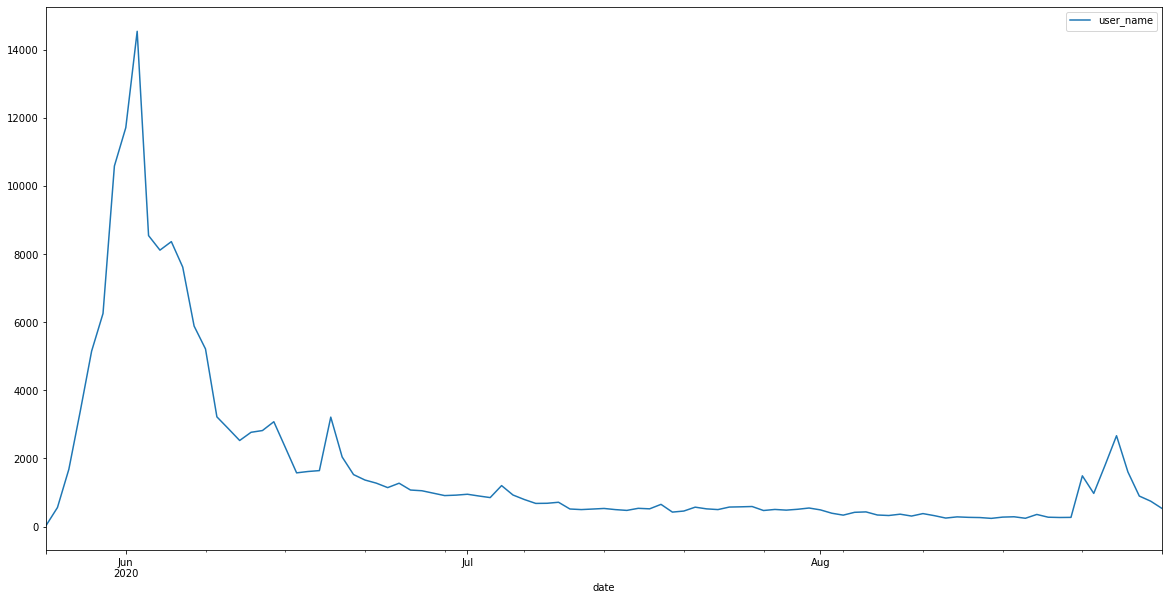

In [47]:
# We look at the volume of tweets published each day and compute its evolution over time
df_t = df.groupby(pd.Grouper(key='date',freq='D'))['user_name'].count()
df_t = df_t.to_frame()
df_t = df_t.loc['2020-05-25':'2020-08-31']
df_t.plot(figsize = (20,10))
plt.show()

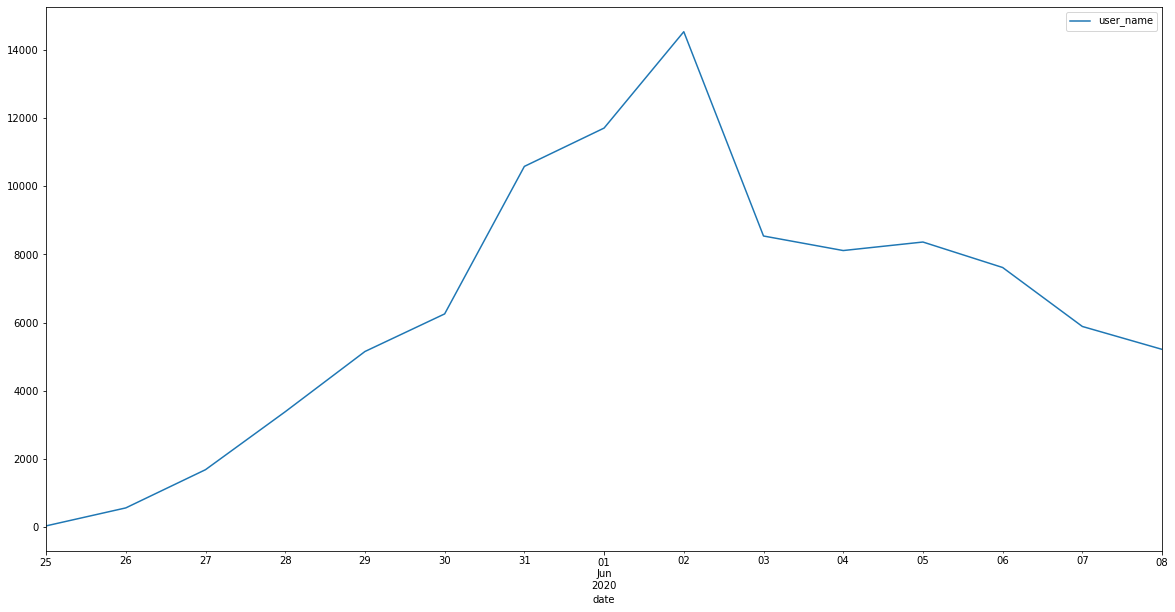

In [48]:
# We zoom on the first week 
df_t_begin = df_t.loc['2020-05-25':'2020-06-08']
df_t_begin.plot(figsize = (20,10))
plt.show()

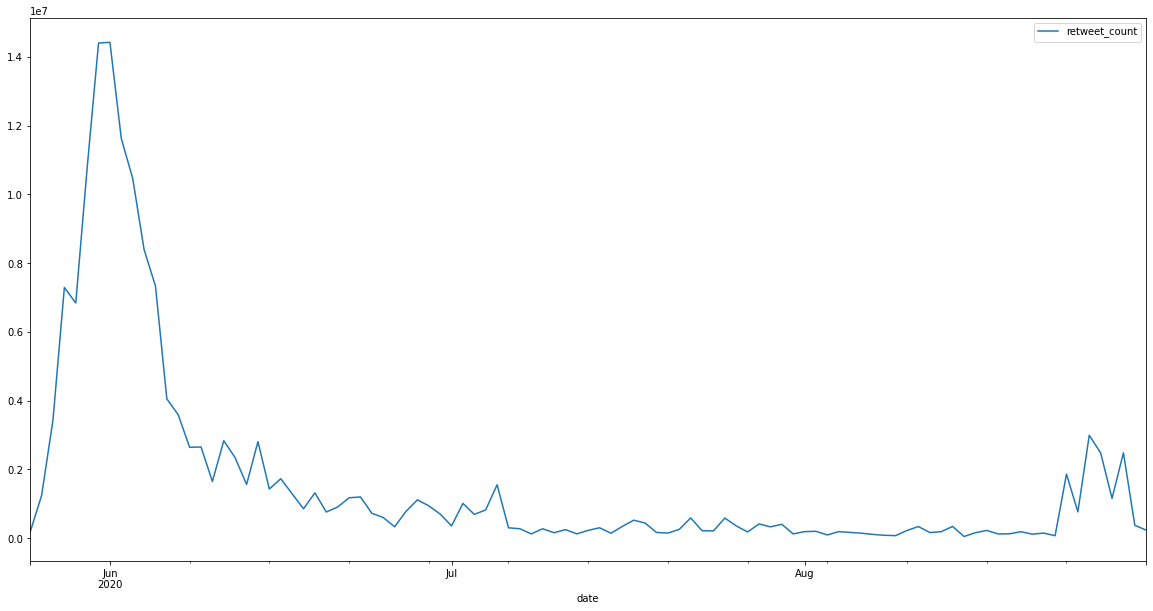

In [49]:
# We compute the evolution of engagement over time 
df_a = df.groupby(pd.Grouper(key='date',freq='D'))['retweet_count'].sum()
df_a = df_a.to_frame()
df_a = df_a.loc['2020-05-25':'2020-08-31']
df_a.plot(figsize = (20,10))
plt.show()

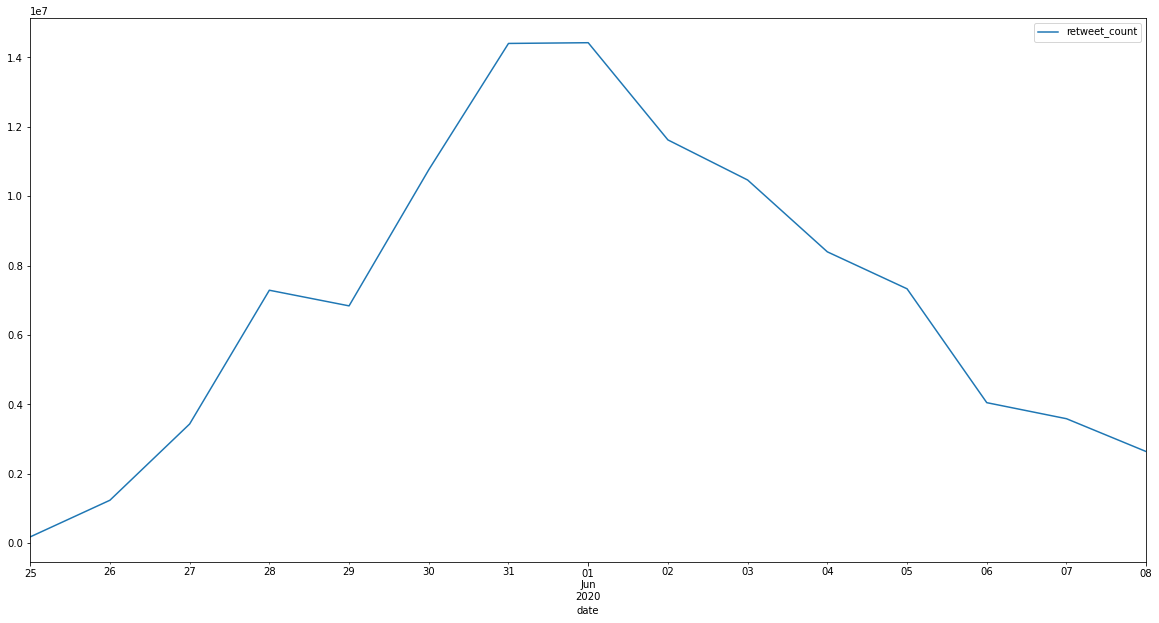

In [50]:
# We zoom on the first week 
df_begin = df_a.loc['2020-05-25':'2020-06-08']
df_begin.plot(figsize = (20,10))
plt.show()

In [51]:
df_z = df.groupby(pd.Grouper(key='date',freq='D'))['user_id'].nunique()
df_z = df_z.to_frame()
df_z = df_z.loc['2020-05-25':'2020-08-31']
df_z.head()

user_id
date               
2020-05-25       21
2020-05-26      470
2020-05-27     1437
2020-05-28     2777
2020-05-29     4242

## We compare the evolution of tweets related to our other queries

In [52]:
# We import tweets related to our other queries
df_defund = pd.read_csv("tweetsgf.csv")
df_wait = pd.read_csv("cantwaittweets.csv")
df_reform = pd.read_csv("tweetsreform.csv")
df_abolition = pd.read_csv("tweetsabo.csv")
df_blm = pd.read_csv("blm.csv")
df_toabolition = pd.read_csv("toabolitiontweets.csv")

In [53]:
df_blm['Theme'] = "BLM"
df_defund['Theme'] = "Defund"
df_wait['Theme'] = "8CantWait"
df_reform['Theme'] = "Reform"
df_abolition['Theme'] = "Abolition"
df_toabolition['Theme'] = "8ToAbolition"

In [54]:
# We join all of these tweets
master_df = df_wait.append(df_reform)
master_df = master_df.append(df_abolition)
master_df = master_df.append(df_toabolition)
master_df = master_df.append(df_defund)
master_df = master_df.append(df_blm)
len(master_df)

192944

In [55]:
# We compute the volume of tweets
df_ma = groupby_date(master_df)
df_ca = df_ma
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca['date'] = df_ca['date'].dt.strftime('%Y-%m-%d')
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-08-31')]
df_byfollow = df_ca.groupby(['date','Theme'])[['id']].count().unstack().fillna(0)
df_byfollow

id                                              
Theme      8CantWait 8ToAbolition Abolition      BLM Defund Reform
date                                                              
2020-05-25       0.0          0.0       0.0     30.0    0.0    0.0
2020-05-26       0.0          0.0       2.0    558.0    0.0    0.0
2020-05-27       0.0          0.0       3.0   1680.0    2.0    0.0
2020-05-28       0.0          0.0       7.0   3381.0    5.0    0.0
2020-05-29       0.0          0.0       8.0   5150.0    8.0    0.0
2020-05-30       0.0          0.0      19.0   6254.0   38.0    0.0
2020-05-31       1.0          0.0      56.0  10584.0  139.0    1.0
2020-06-01       0.0          0.0      35.0  11708.0  142.0    0.0
2020-06-02       1.0          0.0      29.0  14537.0  208.0    0.0
2020-06-03     233.0          0.0      26.0   8540.0  290.0    0.0
2020-06-04     362.0          0.0      54.0   8113.0  342.0    1.0
2020-06-05     176.0          0.0     127.0   8363.0  555.0    3.0
2020-06-06      71.0          0.0      83.0   7615.0  422.0    6.0
2020-06-07      52.0         11.0     131.0   5884.0  637.0   38.0
2020-06-08      37.0         12.0     120.0   5212.0  860.0   73.0
2020-06-09      19.0         17.0      74.0   3219.0  621.0   39.0
2020-06-10      22.0         12.0      49.0   2875.0  438.0   37.0
2020-06-11       5.0         10.0      24.0   2526.0  289.0   14.0
2020-06-12      16.0          3.0      30.0   2766.0  298.0   15.0
2020-06-13       4.0          6.0      35.0   2817.0  280.0   13.0
2020-06-14      11.0          2.0      28.0   3076.0  305.0   14.0
2020-06-15       5.0          6.0      21.0   2329.0  264.0   13.0
2020-06-16       5.0          2.0      23.0   1575.0  234.0   15.0
2020-06-17       3.0          4.0      18.0   1615.0  216.0    9.0
2020-06-18       3.0          4.0      28.0   1641.0  224.0    9.0
2020-06-19       6.0          3.0      27.0   3211.0  210.0   12.0
2020-06-20       1.0          3.0      27.0   2041.0  143.0    5.0
2020-06-21       2.0          4.0      15.0   1524.0  101.0    2.0
2020-06-22       2.0          1.0      25.0   1365.0  131.0    4.0
2020-06-23       2.0          1.0      26.0   1273.0  190.0    2.0
2020-06-24       2.0          3.0      30.0   1142.0  193.0    0.0
2020-06-25       1.0         13.0      31.0   1271.0  189.0    4.0
2020-06-26       1.0          1.0      22.0   1071.0  130.0    1.0
2020-06-27       0.0          4.0      16.0   1050.0  150.0    0.0
2020-06-28       2.0          2.0      22.0    979.0  105.0    2.0
2020-06-29       1.0          4.0      25.0    908.0  138.0    1.0
2020-06-30       0.0          2.0      11.0    921.0  152.0    0.0
2020-07-01       0.0          0.0       3.0    947.0  146.0    4.0
2020-07-02       0.0          1.0      20.0    896.0   83.0    2.0
2020-07-03       1.0          0.0      14.0    849.0   71.0    3.0
2020-07-04       1.0         11.0      19.0   1201.0   84.0    1.0
2020-07-05       1.0          2.0      19.0    925.0   80.0    2.0
2020-07-06       0.0          0.0       7.0    793.0   80.0    2.0
2020-07-07       2.0          1.0       9.0    678.0   75.0   14.0
2020-07-08       1.0          0.0       7.0    682.0   77.0    4.0
2020-07-09       2.0          0.0      12.0    712.0   75.0    0.0
2020-07-10       0.0          0.0      16.0    514.0   69.0    1.0
2020-07-11       1.0          0.0      39.0    498.0   55.0    2.0
2020-07-12       0.0          3.0      36.0    513.0   63.0    0.0
2020-07-13       2.0          4.0       7.0    530.0   78.0    1.0
2020-07-14       1.0          2.0      14.0    496.0   64.0    0.0
2020-07-15       2.0          1.0      16.0    473.0   73.0    1.0
2020-07-16       2.0          1.0      31.0    534.0  111.0    1.0
2020-07-17       1.0          0.0      15.0    519.0  101.0    1.0
2020-07-18       1.0          0.0      35.0    650.0   72.0    2.0
2020-07-19       0.0          0.0      23.0    423.0   79.0    0.0
2020-07-20       0.0          0.0       3.0    454.0   59.0    0.

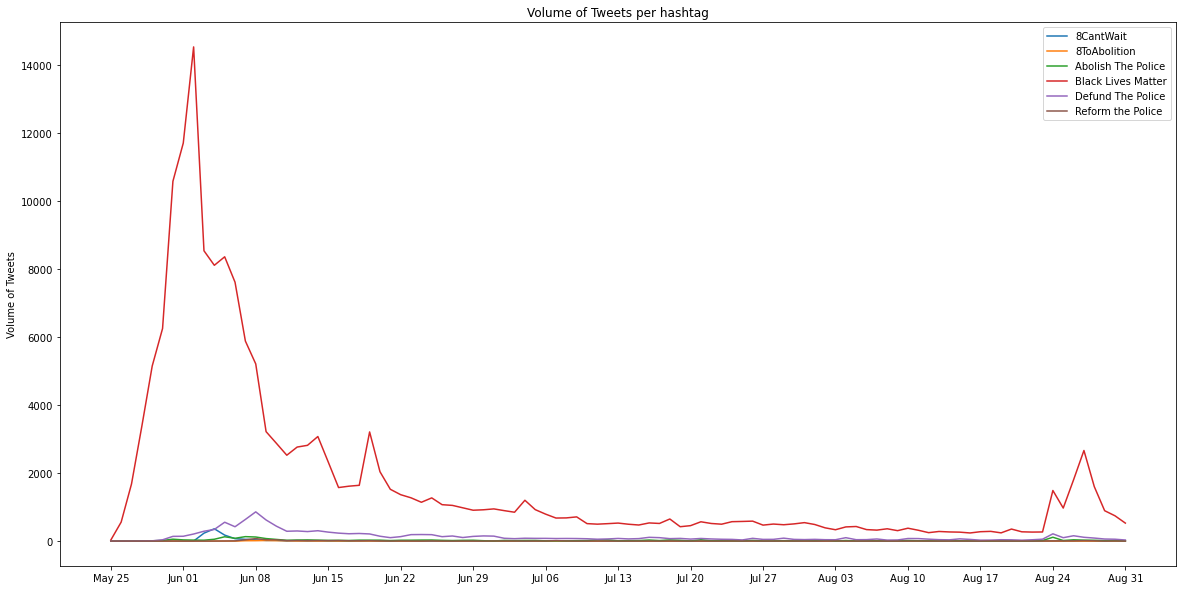

In [56]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byfollow, linestyle='-')
ax.set_ylabel('Volume of Tweets')
ax.set_title('Volume of Tweets per hashtag')
ax.legend(["8CantWait","8ToAbolition","Abolish The Police", "Black Lives Matter", "Defund The Police","Reform the Police"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

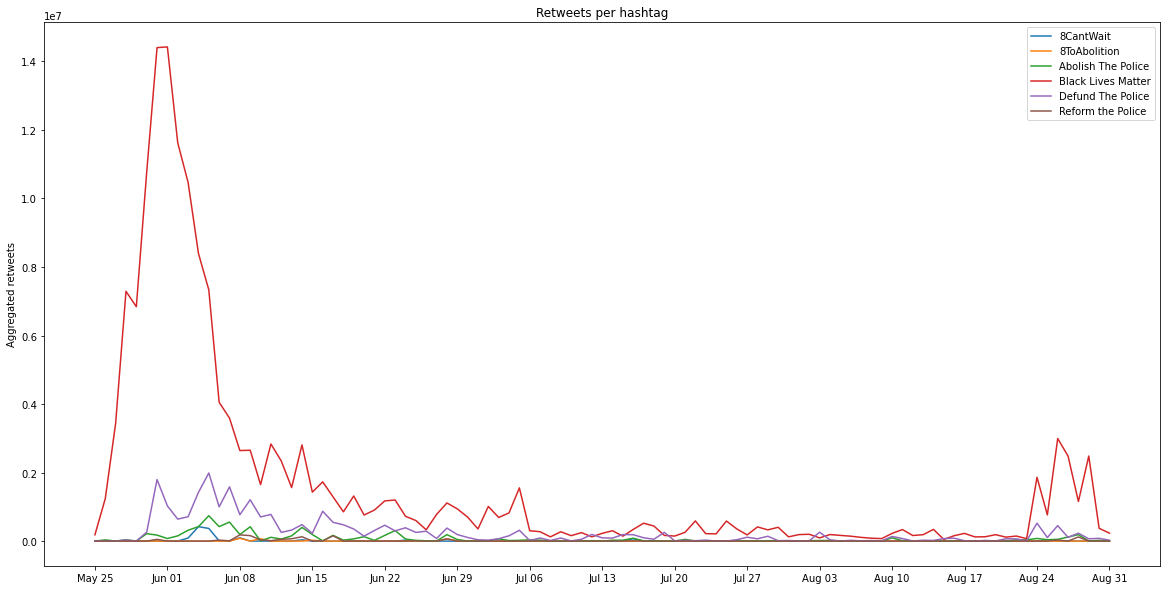

In [57]:
# We compute the volume of retweets
df_byretweet = df_ca.groupby(['date','Theme'])[['retweet_count']].sum().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byretweet, linestyle='-')
ax.set_ylabel('Aggregated retweets')
ax.set_title('Retweets per hashtag')
ax.legend(["8CantWait","8ToAbolition","Abolish The Police", "Black Lives Matter", "Defund The Police","Reform the Police"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

## We now situate the two top queries within a hashtag networks generated by the Twitter Explorer, that computes hashtag co-occurences 

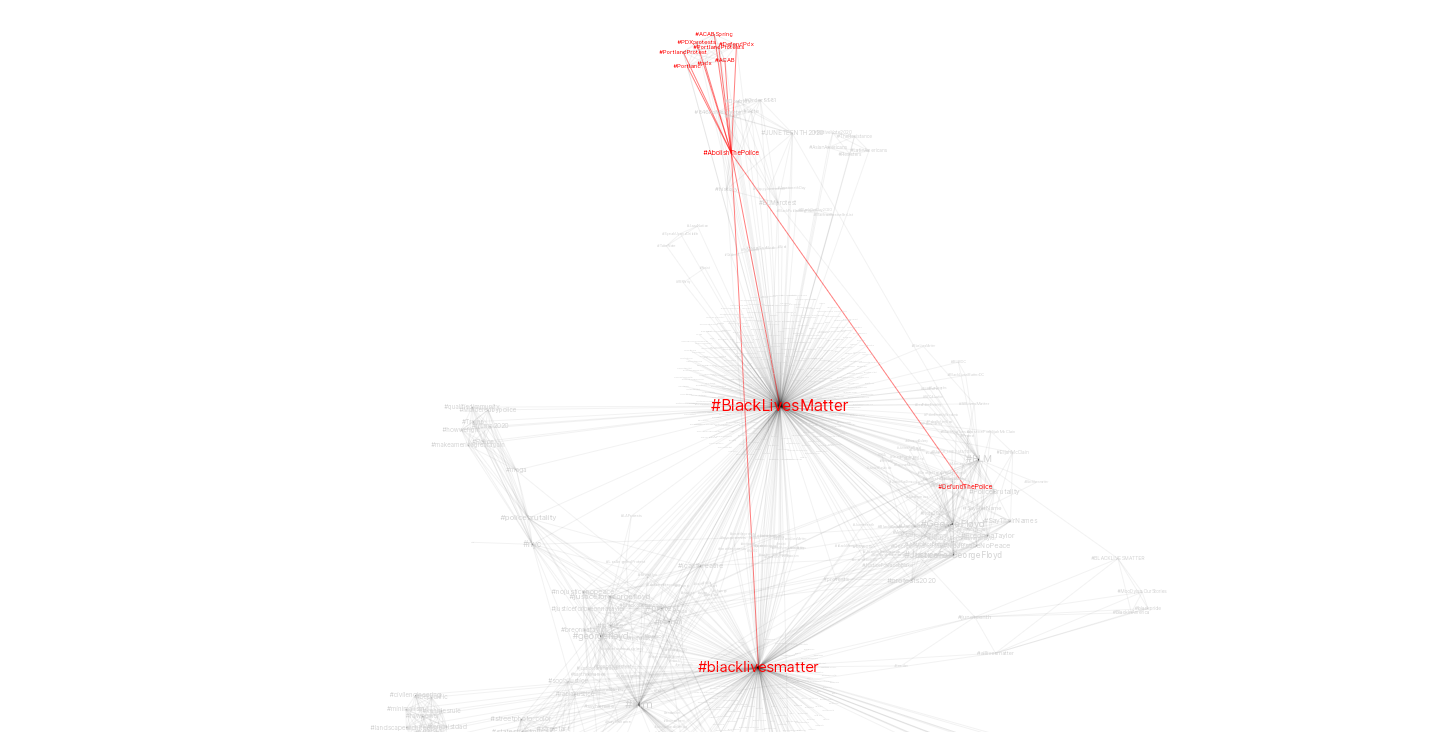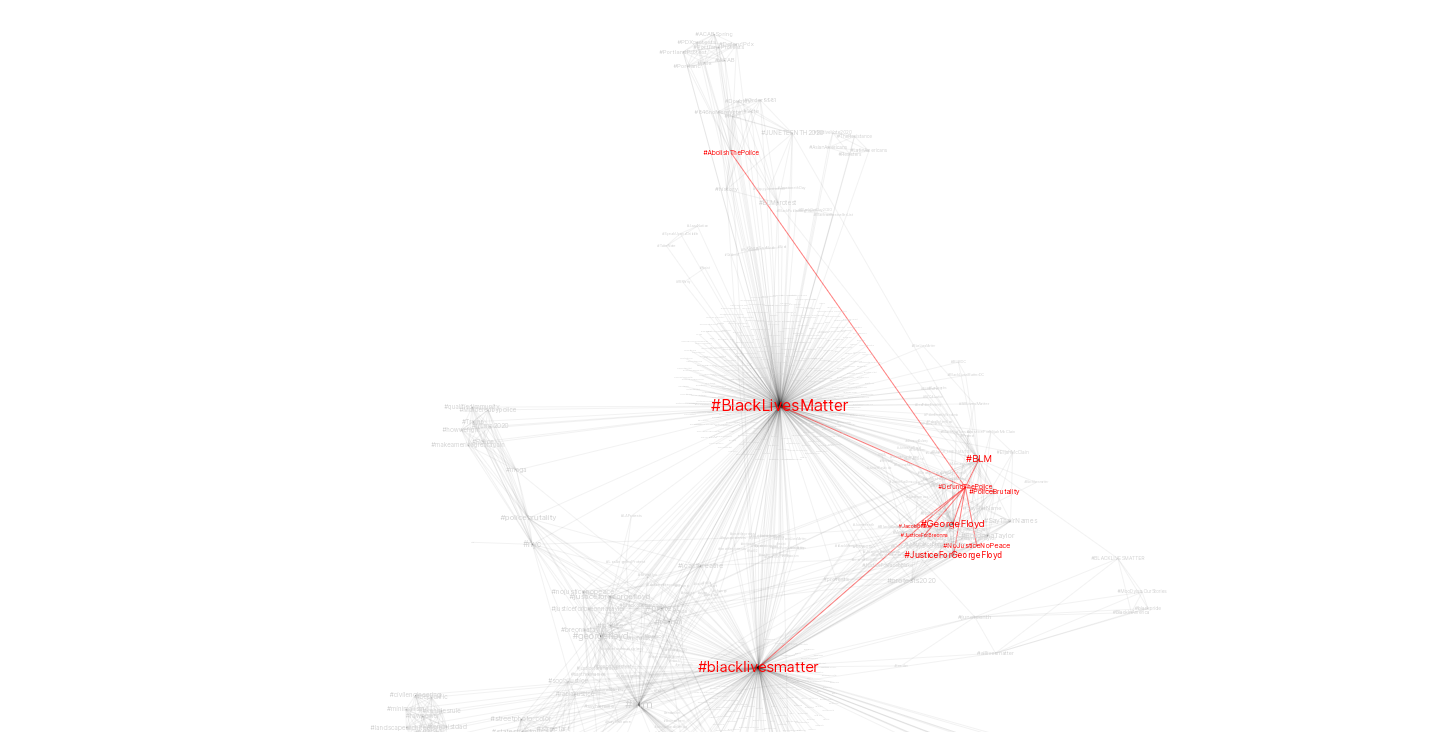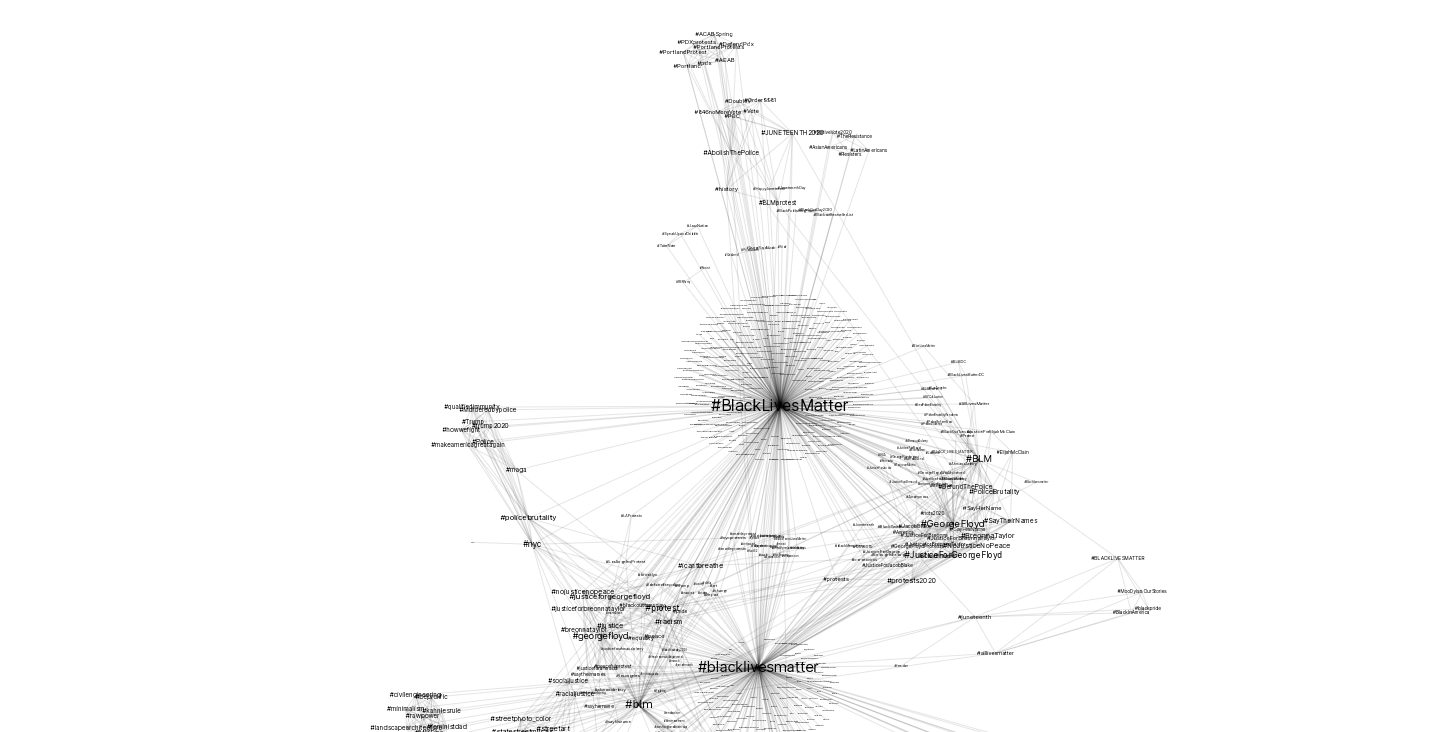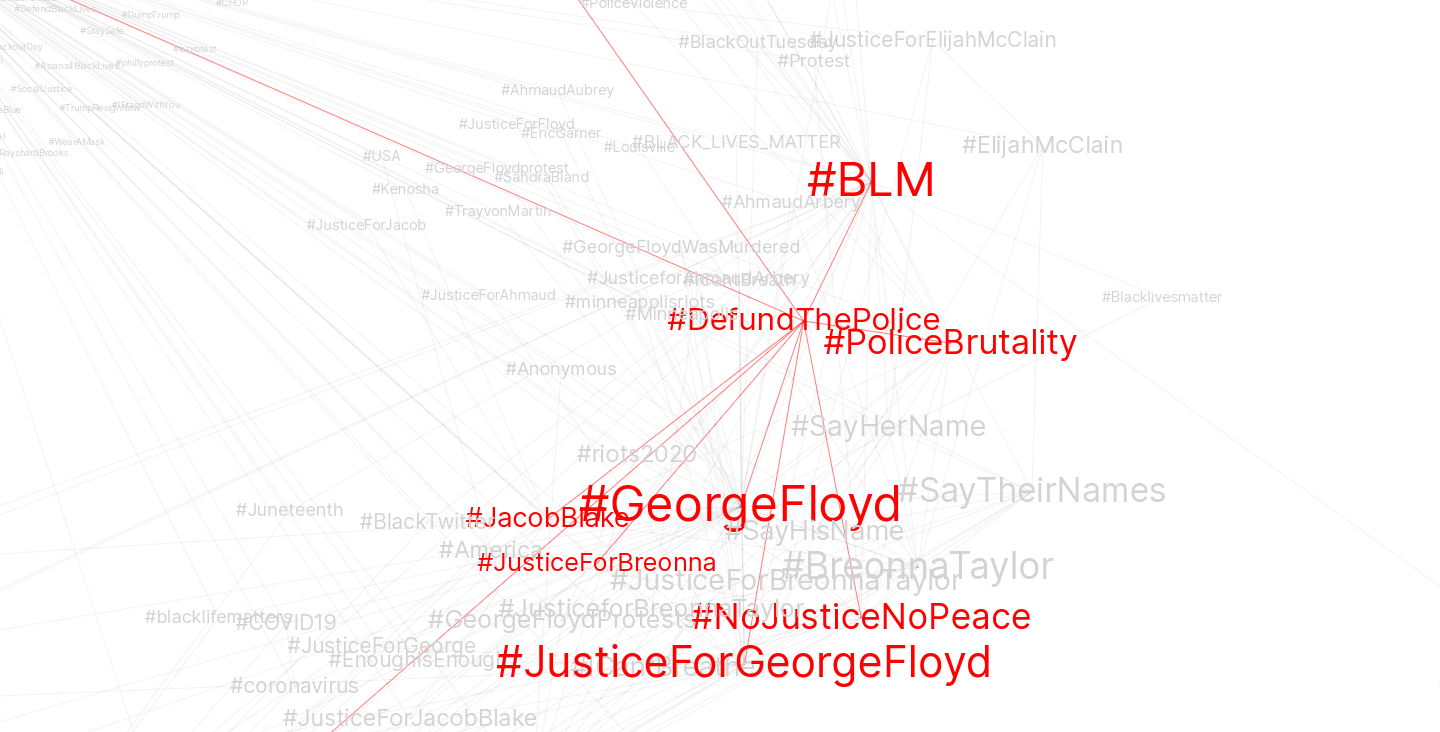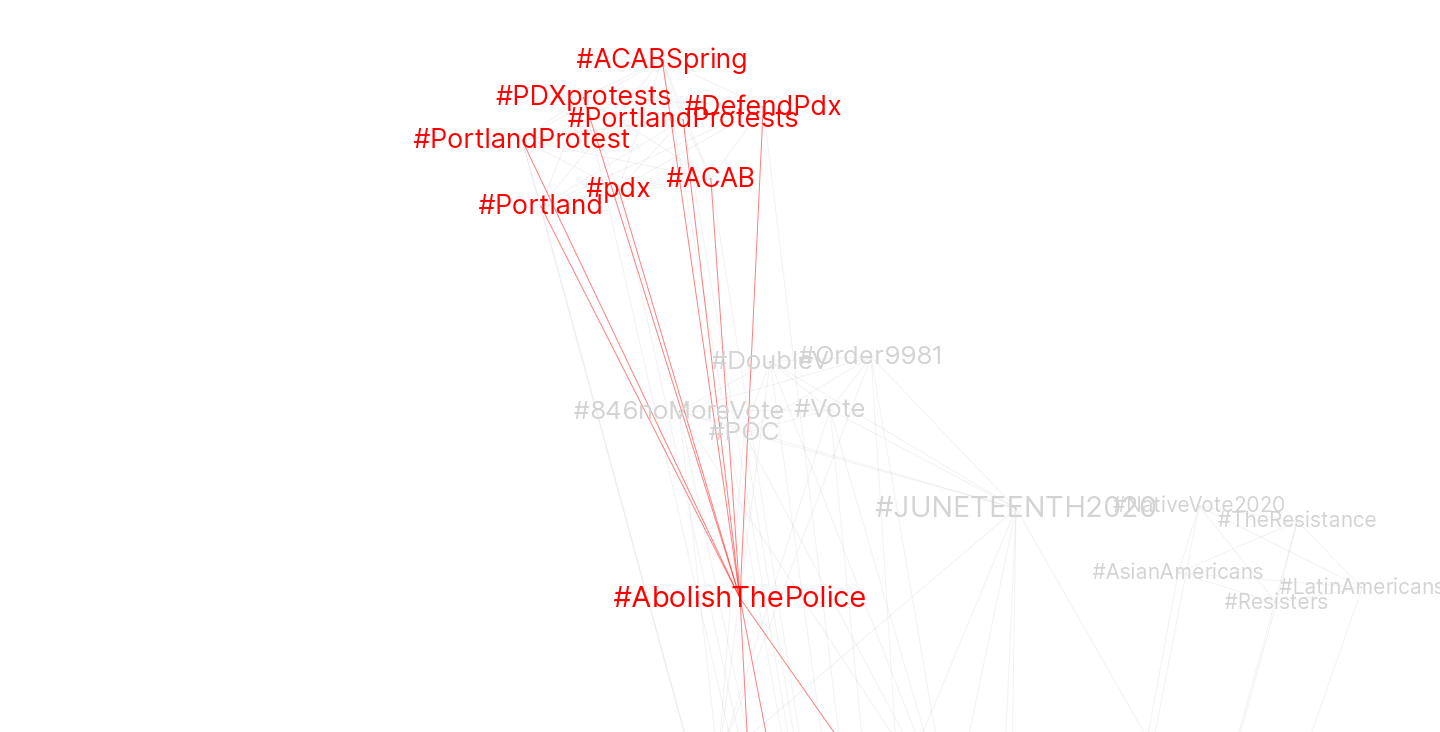

# Themes and frames 

In [58]:
# Themes and frames 

## Topic Modelling analysis 

In [59]:
## We carry out a topic modelling analysis of these different hashtags. We begin by analysing the entire dataset. To do so we clean the data. 

### Topic modelling: entire corpus

In [60]:
import preprocessor as p

In [61]:
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    return text
master_df['text'] = master_df.apply(preprocess_tweet, axis=1)
from gensim.parsing.preprocessing import remove_stopwords
def stopword_removal(row):
    text = row['text']
    text = remove_stopwords(text)
    return text
master_df['text'] = master_df.apply(stopword_removal, axis=1)
master_df['text'] = master_df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
documents = list(master_df['text'].str.lower())

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/1965328838.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  master_df['text'] = master_df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [62]:
## instantiate the corpus object
lang = 'en_core_web_sm'
corpus = textacy.Corpus(lang)
for item in ['parser']:
  if item in corpus.spacy_lang.pipe_names:
      corpus.spacy_lang.remove_pipe(item)
## add the documents 
corpus.add_texts(documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)
tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [63]:
import textacy.tm
model = textacy.tm.TopicModel("nmf", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [64]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: black   woman   community   mourn   brown   fight   business   sister   folk   brother
topic 1: police   brutality   officer   violence   protester   department   force   reform   city   murder
topic 2: people   chain   color   t   power   lot   innocent   country   tired   skin
topic 3: community   change   right   support   movement   way   thing   world   voice   good
topic 4: life   matter   movement   blue   human   plaza   t   black   street   mural
topic 5: protest   peaceful   protester   downtown   city   protestor   tonight   street   riot   safe
topic 6: white   racist   privilege   supremacy   supremacist   person   folk   friend   thing   america
topic 7: day   music   soul   lovely   therapy   vote   absentee   great   mail   arrest
topic 8: time   tired   talent   promise   rescindeddonate   treasure   long   year   past   genius
topic 9: cop   good   bad   arrest   racist   violent   protester   fuck   thug   murder
topic 10: today   proud   year   pm   tomorro

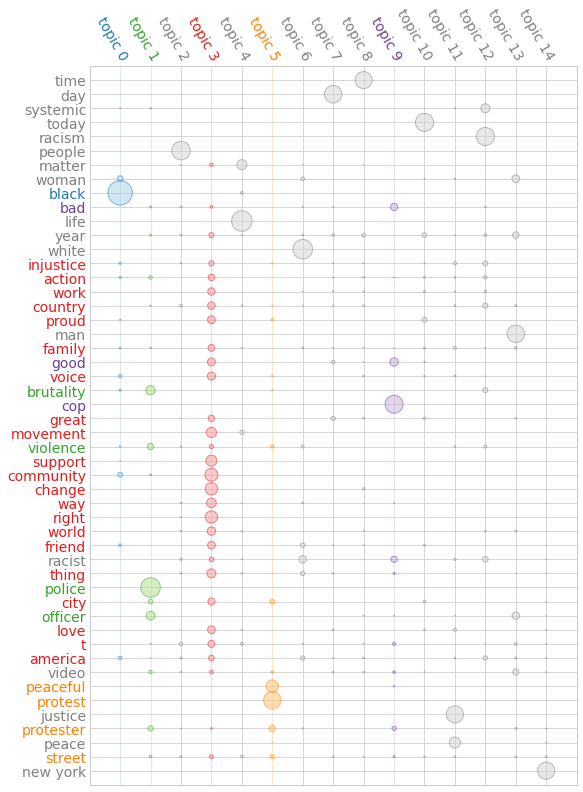

In [65]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=50, highlight_topics=[0,1, 3, 5, 9])

### Topic modelling Defund The Police

In [66]:
df = pd.read_csv("tweetsgf.csv")
tweets = df
tweets['text'] = tweets.apply(preprocess_tweet, axis=1)
tweets['text'] = tweets.apply(stopword_removal, axis=1)
tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/3450676151.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [67]:
documents = list(tweets['text'].str.lower())

In [68]:
## instantiate the corpus object
lang = 'en_core_web_sm'
corpus = textacy.Corpus(lang)
for item in ['parser']:
  if item in corpus.spacy_lang.pipe_names:
      corpus.spacy_lang.remove_pipe(item)
## add the documents 
corpus.add_texts(documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)
tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [69]:
model = textacy.tm.TopicModel("nmf", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [70]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: police   defund   department   brutality   reform   violence   union   force   immunity   state
topic 1: people   white   power   change   harming   t   real   problem   murder   american
topic 2: cop   violent   thug   arrest   past   shit   racist   fuck   fucking   t
topic 3: health   mental   social   service   worker   housing   education   fund   program   crisis
topic 4: black   life   brown   matter   harming   folk   unarmed   family   justice   racism
topic 5: officer   court   guilty   car   action   charge   multiple   body   home   atlanta
topic 6: budget   city   cut   mayor   department   demand   support   street   increase   little
topic 7: time   past   violent   thug   reform   great   justice   change   hil   hard
topic 8: protest   peaceful   protester   today   gas   protestor   tear   right   jail   day
topic 9: school   public   student   teacher   safety   money   board   prison   district   child
topic 10: community   money   safety   fund   program  

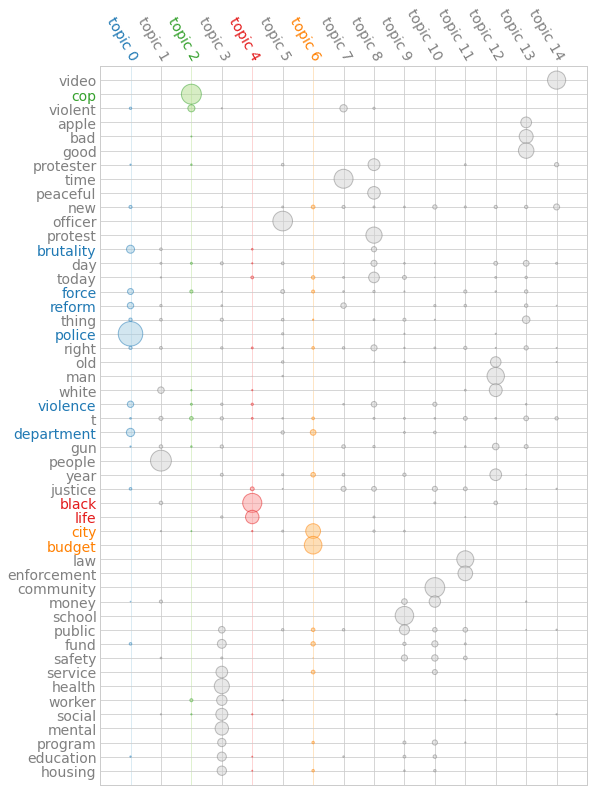

In [71]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=50, highlight_topics=[0,4,6,2])

### Topic modelling Abolish The Police

In [72]:
df = pd.read_csv("tweetsabo.csv")
tweets = df
tweets['text'] = tweets.apply(preprocess_tweet, axis=1)
tweets['text'] = tweets.apply(stopword_removal, axis=1)
tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/2626436347.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [73]:
documents = list(tweets['text'].str.lower())

In [74]:
## instantiate the corpus object
lang = 'en_core_web_sm'
corpus = textacy.Corpus(lang)
for item in ['parser']:
  if item in corpus.spacy_lang.pipe_names:
      corpus.spacy_lang.remove_pipe(item)
## add the documents 
corpus.add_texts(documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)
tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [75]:
model = textacy.tm.TopicModel("nmf", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [76]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: police   violence   brutality   force   reform   year   community   defund   department   protest
topic 1: violent   time   thug   past   cop   murderer   disgusting   multiple   day   gross
topic 2: people   harming   black   problem   white   reform   authority   violence   pig   real
topic 3: bullet   hole   holessix   god   breaking   fight   body   police   rubber   murder
topic 4: video   camera   man   miami   bottle   elderly   incident   criminal   help   york
topic 5: cop   arrest   good   thing   kid   child   leg   nypd   gun   prison
topic 6: officer   woman   man   new   rock   investigation   multiple   explosive   riot   individual
topic 7: public   law   enforcement   community   new   safety   service   fund   program   funding
topic 8: black   man   life   harming   dog   unarmed   week   crime   attack   story
topic 9: white   supremacist   supremacy   racist   boy   murder   protestor   class   agenda   death
topic 10: bad   apple   good   bunch   t   enti

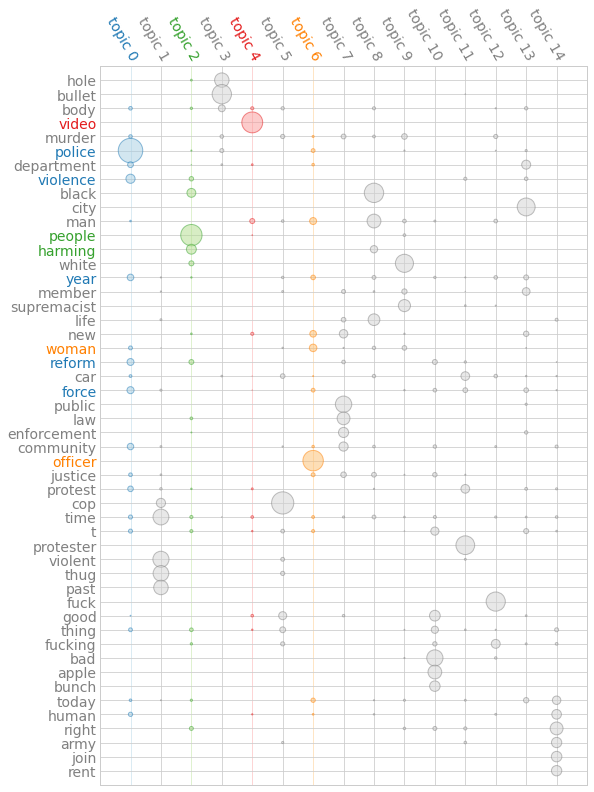

In [77]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=50, highlight_topics=[0,4,6,2])

### Topic modelling analysis Reform the Police 

In [78]:
df = pd.read_csv("tweetsreform.csv")
tweets = df
tweets['text'] = tweets.apply(preprocess_tweet, axis=1)
tweets['text'] = tweets.apply(stopword_removal, axis=1)
tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/2645327351.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [79]:
documents = list(tweets['text'].str.lower())

In [80]:
## instantiate the corpus object
lang = 'en_core_web_sm'
corpus = textacy.Corpus(lang)
for item in ['parser']:
  if item in corpus.spacy_lang.pipe_names:
      corpus.spacy_lang.remove_pipe(item)
## add the documents 
corpus.add_texts(documents)
docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)
tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
id_to_term = {id_: term for term, id_ in vocab.items()}

In [81]:
model = textacy.tm.TopicModel("nmf", n_topics=15)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/HannaAgbanrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [82]:
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=10):
    print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: team   outside   monitor   crisis   camera   escalation   need   accountable   new   training
topic 1: police   defund   reform   choice   weapon   department   end   change   wrong   practice
topic 2: officer   skilled   peace   negotiating   defense   separate   branch   tension   self   unarmed
topic 3: union   r   worker   right   fraternal   funny   impediment   past   clear   real
topic 4: black   man   white   brown   unarmed   police   neck   time   narrative   people
topic 5: cop   good   stop   life   threatening   automate   prevent   speeding   ticket   dangerous
topic 6: t   folk   skin   ain   nope   doesn   insulting   mean   black   brooks well
topic 7: friend   racist   different   double   progressive   responsibility   pair   form   color   meaning
topic 8: people   sick   lot   mad   reform   unemployed   work   racism   policeman   neck
topic 9: job   protest   one   murder   mission   police   nurse   patient   accountability   accountable
topic 10: case 

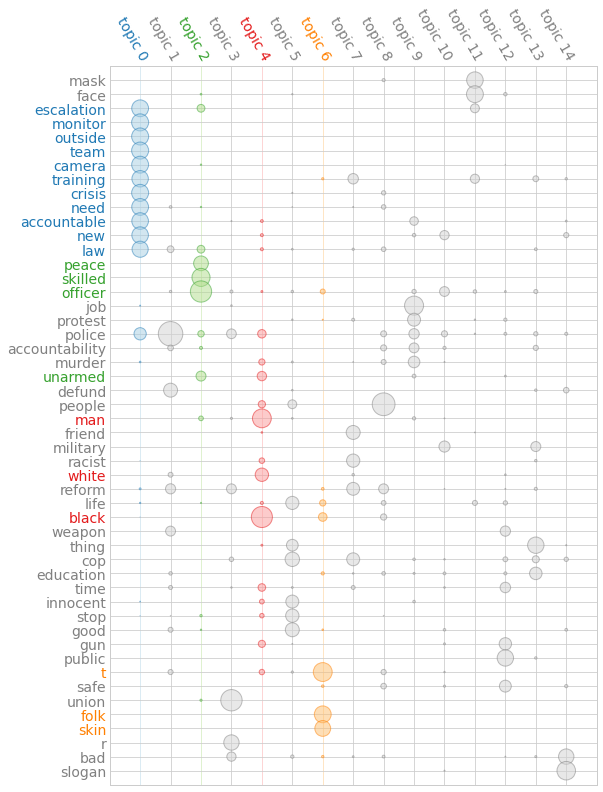

In [83]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=50, highlight_topics=[0,4,6,2])

## TF-IDF Analysis 

In [84]:
df_analysis = master_df.groupby('Theme').agg({'text': lambda x: list(x)})
df_analysis['liststring'] = [','.join(map(str, l)) for l in df_analysis['text']]

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
pd.set_option("max_rows", 600)
from pathlib import Path  
import glob

In [86]:
df_analysis = df_analysis.reset_index()

In [87]:
#import the function CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Create our CountVectorizer object
countvec = CountVectorizer()

sklearn_dtm = countvec.fit_transform(df_analysis.liststring)
print(sklearn_dtm)

  (0, 44293)	3
  (0, 10985)	5
  (0, 42624)	7
  (0, 34107)	4
  (0, 39426)	12
  (0, 14013)	2
  (0, 40849)	457
  (0, 14703)	14
  (0, 12690)	15
  (0, 30204)	1
  (0, 54967)	7
  (0, 5622)	5
  (0, 53106)	11
  (0, 40457)	26
  (0, 22522)	30
  (0, 53537)	6
  (0, 24418)	20
  (0, 52781)	94
  (0, 58812)	6
  (0, 12987)	1
  (0, 25978)	166
  (0, 39022)	1
  (0, 25292)	9
  (0, 17073)	2
  (0, 17410)	1
  :	:
  (5, 6784)	1
  (5, 31026)	1
  (5, 43962)	1
  (5, 40861)	1
  (5, 8292)	1
  (5, 32630)	1
  (5, 50324)	1
  (5, 41557)	1
  (5, 42637)	1
  (5, 57853)	1
  (5, 39128)	1
  (5, 18452)	1
  (5, 40876)	1
  (5, 21554)	1
  (5, 624)	3
  (5, 517)	1
  (5, 15869)	1
  (5, 22662)	2
  (5, 519)	1
  (5, 15871)	1
  (5, 9369)	1
  (5, 520)	1
  (5, 15872)	1
  (5, 22664)	1
  (5, 55965)	1


In [88]:
dtm_df = pd.DataFrame(countvec.fit_transform(df_analysis.liststring).toarray(), columns=countvec.get_feature_names(), index = df_analysis.Theme)
dtm_df

00  000  0006  000and  000over  000thats  000to  005  00am  \
Theme                                                                       
8CantWait       0    0     0       0        0         0      0    0     0   
8ToAbolition    0    2     0       0        0         0      0    0     0   
Abolition       0    2     0       0        0         1      0    0     0   
BLM           152  172     1       1        1         1      1    2    28   
Defund          8   40     0       0        0         1      0    0     0   
Reform          0    1     0       0        0         0      0    0     0   

              00amwhere  ...  zukerberg  zulu  zumba  zumwalt  zuni  zuri  \
Theme                    ...                                                
8CantWait             0  ...          0     0      0        0     0     0   
8ToAbolition          0  ...          0     0      0        0     0     0   
Abolition             0  ...          0     0      0        0     0     0   
BLM                   1  ...          1     1      3        1     1     3   
Defund                0  ...          0     0      1        0     0     0   
Reform                0  ...          0     0      0        0     0     0   

              zurich  zuris  zy  zz  
Theme                                
8CantWait          0      0   0   0  
8ToAbolition       0      0   0   0  
Abolition          0      0   0   0  
BLM                1      1   1   1  
Defund             0      0   0   0  
Reform             0      0   0   0  

[6 rows x 59958 columns]

In [89]:
#import the function
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer()

#create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pd.DataFrame(tfidfvec.fit_transform(df_analysis.liststring).toarray(), columns=tfidfvec.get_feature_names(), index = df_analysis.Theme)

#view results
dtm_tfidf_df

00       000     0006   000and  000over  000thats  \
Theme                                                                   
8CantWait     0.000000  0.000000  0.00000  0.00000  0.00000  0.000000   
8ToAbolition  0.000000  0.021352  0.00000  0.00000  0.00000  0.000000   
Abolition     0.000000  0.002066  0.00000  0.00000  0.00000  0.001396   
BLM           0.003679  0.002601  0.00003  0.00003  0.00003  0.000020   
Defund        0.002250  0.007029  0.00000  0.00000  0.00000  0.000237   
Reform        0.000000  0.003621  0.00000  0.00000  0.00000  0.000000   

                000to       005      00am  00amwhere  ...  zukerberg     zulu  \
Theme                                                 ...                       
8CantWait     0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
8ToAbolition  0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
Abolition     0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
BLM           0.00003  0.000059  0.000827    0.00003  ...    0.00003  0.00003   
Defund        0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
Reform        0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   

                 zumba  zumwalt     zuni      zuri   zurich    zuris       zy  \
Theme                                                                           
8CantWait     0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
8ToAbolition  0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
Abolition     0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
BLM           0.000073  0.00003  0.00003  0.000089  0.00003  0.00003  0.00003   
Defund        0.000281  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
Reform        0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   

                   zz  
Theme                  
8CantWait     0.00000  
8ToAbolition  0.00000  
Abolition     0.00000  
BLM           0.00003  
Defund        0.00000  
Reform        0.00000  

[6 rows x 59958 columns]

In [90]:
dtm_tfidf_df

00       000     0006   000and  000over  000thats  \
Theme                                                                   
8CantWait     0.000000  0.000000  0.00000  0.00000  0.00000  0.000000   
8ToAbolition  0.000000  0.021352  0.00000  0.00000  0.00000  0.000000   
Abolition     0.000000  0.002066  0.00000  0.00000  0.00000  0.001396   
BLM           0.003679  0.002601  0.00003  0.00003  0.00003  0.000020   
Defund        0.002250  0.007029  0.00000  0.00000  0.00000  0.000237   
Reform        0.000000  0.003621  0.00000  0.00000  0.00000  0.000000   

                000to       005      00am  00amwhere  ...  zukerberg     zulu  \
Theme                                                 ...                       
8CantWait     0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
8ToAbolition  0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
Abolition     0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
BLM           0.00003  0.000059  0.000827    0.00003  ...    0.00003  0.00003   
Defund        0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   
Reform        0.00000  0.000000  0.000000    0.00000  ...    0.00000  0.00000   

                 zumba  zumwalt     zuni      zuri   zurich    zuris       zy  \
Theme                                                                           
8CantWait     0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
8ToAbolition  0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
Abolition     0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
BLM           0.000073  0.00003  0.00003  0.000089  0.00003  0.00003  0.00003   
Defund        0.000281  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   
Reform        0.000000  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000   

                   zz  
Theme                  
8CantWait     0.00000  
8ToAbolition  0.00000  
Abolition     0.00000  
BLM           0.00003  
Defund        0.00000  
Reform        0.00000  

[6 rows x 59958 columns]

In [91]:
#Copy our tfidf df to a new df to add genre this is the one
dtm_tfidf_df_retweet = dtm_tfidf_df
dtm_tfidf_df_retweet['THEME'] = ["8cantwait", "8toAbolition", "abolition", "BLM", "defund", "reform"] 

In [92]:
dtm_tfidf_df_retweet

00       000     0006   000and  000over  000thats  \
Theme                                                                   
8CantWait     0.000000  0.000000  0.00000  0.00000  0.00000  0.000000   
8ToAbolition  0.000000  0.021352  0.00000  0.00000  0.00000  0.000000   
Abolition     0.000000  0.002066  0.00000  0.00000  0.00000  0.001396   
BLM           0.003679  0.002601  0.00003  0.00003  0.00003  0.000020   
Defund        0.002250  0.007029  0.00000  0.00000  0.00000  0.000237   
Reform        0.000000  0.003621  0.00000  0.00000  0.00000  0.000000   

                000to       005      00am  00amwhere  ...     zulu     zumba  \
Theme                                                 ...                      
8CantWait     0.00000  0.000000  0.000000    0.00000  ...  0.00000  0.000000   
8ToAbolition  0.00000  0.000000  0.000000    0.00000  ...  0.00000  0.000000   
Abolition     0.00000  0.000000  0.000000    0.00000  ...  0.00000  0.000000   
BLM           0.00003  0.000059  0.000827    0.00003  ...  0.00003  0.000073   
Defund        0.00000  0.000000  0.000000    0.00000  ...  0.00000  0.000281   
Reform        0.00000  0.000000  0.000000    0.00000  ...  0.00000  0.000000   

              zumwalt     zuni      zuri   zurich    zuris       zy       zz  \
Theme                                                                          
8CantWait     0.00000  0.00000  0.000000  0.00000  0.00000  0.00000  0.00000   
8ToAbolition  0.00000  0.00000  0.000000  0.00000  0.00000  0.00000  0.00000   
Abolition     0.00000  0.00000  0.000000  0.00000  0.00000  0.00000  0.00000   
BLM           0.00003  0.00003  0.000089  0.00003  0.00003  0.00003  0.00003   
Defund        0.00000  0.00000  0.000000  0.00000  0.00000  0.00000  0.00000   
Reform        0.00000  0.00000  0.000000  0.00000  0.00000  0.00000  0.00000   

                     THEME  
Theme                       
8CantWait        8cantwait  
8ToAbolition  8toAbolition  
Abolition        abolition  
BLM                    BLM  
Defund              defund  
Reform              reform  

[6 rows x 59959 columns]

In [94]:
dtm_8abo = dtm_tfidf_df_retweet[dtm_tfidf_df_retweet['THEME']=="8toAbolition"]
dtm_abo = dtm_tfidf_df_retweet[dtm_tfidf_df_retweet['THEME']=="abolition"]
dtm_defund = dtm_tfidf_df_retweet[dtm_tfidf_df_retweet['THEME']=="defund"]
dtm_reform = dtm_tfidf_df_retweet[dtm_tfidf_df_retweet['THEME']=="reform"]
dtm_blm = dtm_tfidf_df_retweet[dtm_tfidf_df_retweet['THEME']=="BLM"]
dtm_8cantwait = dtm_tfidf_df_retweet[dtm_tfidf_df_retweet['THEME']=="8cantwait"]
#print the words with the highest tf-idf scores for each genre
print("BLM")
print(dtm_blm.max(numeric_only=True).sort_values(ascending=False)[0:20])
print("8cantwait")
print(dtm_8cantwait.max(numeric_only=True).sort_values(ascending=False)[0:20])
print()
print("8toAbolition")
print(dtm_8abo.max(numeric_only=True).sort_values(ascending=False)[0:20])
print()
print("Abolition")
print(dtm_abo.max(numeric_only=True).sort_values(ascending=False)[0:20])
print("Defund")
print(dtm_defund.max(numeric_only=True).sort_values(ascending=False)[0:20])
print("Reform")
print(dtm_reform.max(numeric_only=True).sort_values(ascending=False)[0:20])

BLM
black      0.359263
people     0.244134
this       0.236862
the        0.208715
we         0.208689
you        0.189335
police     0.164110
it         0.159209
lives      0.148858
protest    0.135628
matter     0.126909
today      0.118824
white      0.117107
im         0.102562
dont       0.100256
like       0.098395
justice    0.093285
stand      0.090167
time       0.087703
support    0.086550
dtype: float64
8cantwait
policies    0.404221
police      0.383828
urge        0.266572
enact       0.248881
violence    0.190654
reduce      0.188055
we          0.187294
local       0.179597
mayors      0.177352
joining     0.152658
cities      0.149281
stake       0.144800
im          0.139421
results     0.138618
wait        0.125983
death       0.125983
power       0.125143
more        0.122623
learn       0.122623
join        0.122623
dtype: float64

8toAbolition
people       0.342251
police       0.268251
holmes       0.187963
gunfire      0.158691
cops         0.157250
bc          

## We look at the evolution of these frames overtime


### DefundThePolice Overtime

In [100]:
df = pd.read_csv("tweetsgf.csv")
df = groupby_date(df)
tweets = df
tweets['text'] = tweets.apply(preprocess_tweet, axis=1)
tweets['text'] = tweets.apply(stopword_removal, axis=1)
tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/178322677.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [103]:
tweets_date = tweets.groupby(pd.Grouper(key='date',freq='W')).agg({'text': lambda x: list(x)})
tweets_date = tweets_date.loc['2020-05-25':'2020-08-31']

In [104]:
tweets_date['liststring'] = [','.join(map(str, l)) for l in tweets_date['text']]
tweets_date['week']= ['week 1', 'week 2', 'week 3', 'week 4', 'week 5','week 6','week 7','week 8','week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14']
#import the function CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Create our CountVectorizer object
countvec = CountVectorizer()

sklearn_dtm = countvec.fit_transform(tweets_date.liststring)
print(sklearn_dtm)

  (0, 7694)	4
  (0, 9332)	1
  (0, 10666)	1
  (0, 10877)	2
  (0, 2361)	4
  (0, 4644)	1
  (0, 7303)	13
  (0, 13181)	2
  (0, 13158)	1
  (0, 8417)	1
  (0, 10117)	4
  (0, 3509)	3
  (0, 4714)	2
  (0, 1695)	1
  (0, 2118)	1
  (0, 13901)	1
  (0, 7814)	4
  (0, 12861)	1
  (0, 10602)	1
  (0, 4565)	3
  (0, 8070)	1
  (0, 8456)	1
  (0, 11971)	1
  (0, 8769)	1
  (0, 10098)	77
  :	:
  (13, 9487)	1
  (13, 5828)	1
  (13, 8218)	1
  (13, 8982)	1
  (13, 80)	1
  (13, 2407)	1
  (13, 11470)	1
  (13, 2457)	1
  (13, 12060)	1
  (13, 11626)	1
  (13, 7123)	1
  (13, 783)	2
  (13, 6819)	1
  (13, 4809)	1
  (13, 2574)	1
  (13, 6567)	1
  (13, 570)	1
  (13, 14707)	1
  (13, 11767)	1
  (13, 9043)	1
  (13, 831)	1
  (13, 7307)	1
  (13, 2849)	1
  (13, 7545)	1
  (13, 9093)	1


In [105]:
tweets_date = tweets_date.reset_index()

In [106]:
dtm_df = pd.DataFrame(countvec.fit_transform(tweets_date.liststring).toarray(), columns=countvec.get_feature_names(), index = tweets_date.date)
dtm_df

00  000  000thats  00p  00pm  00pmoregon  01  03  04  06  ...  \
date                                                                  ...   
2020-05-31   0    0         0    0     0           0   0   0   0   0  ...   
2020-06-07   2    3         1    0     1           0   0   0   1   2  ...   
2020-06-14   4   17         0    1     0           0   2   1   0   1  ...   
2020-06-21   0    5         0    0     0           0   0   0   0   0  ...   
2020-06-28   0    1         0    0     0           0   0   0   0   0  ...   
2020-07-05   0    7         0    0     0           0   0   0   0   0  ...   
2020-07-12   0    0         0    0     0           0   0   0   0   0  ...   
2020-07-19   0    1         0    0     1           0   0   0   0   0  ...   
2020-07-26   1    1         0    0     1           0   0   0   0   0  ...   
2020-08-02   0    1         0    0     0           1   0   0   0   0  ...   
2020-08-09   0    0         0    0     1           0   0   0   0   0  ...   
2020-08-16   0    1         0    0     0           0   0   0   0   0  ...   
2020-08-23   0    1         0    0     0           0   0   0   0   0  ...   
2020-08-30   1    2         0    0     0           0   0   0   0   0  ...   

            zion  zip  ziptied  zombie  zone  zones  zoning  zoom  zordon  \
date                                                                        
2020-05-31     0    0        0       0     0      0       0     0       0   
2020-06-07     0    1        2       0     1      0       0     4       0   
2020-06-14     0    0        0       0     6      1       1     6       2   
2020-06-21     2    1        0       0     2      1       0     0       0   
2020-06-28     0    0        0       0     0      0       0     1       0   
2020-07-05     0    0        0       0     0      0       0     0       0   
2020-07-12     0    0        0       0     1      0       0     0       0   
2020-07-19     0    0        0       0     1      0       0     2       0   
2020-07-26     0    0        0       0     2      2       0     0       0   
2020-08-02     0    0        0       0     1      0       0     2       0   
2020-08-09     0    0        0       0     0      0       0     0       0   
2020-08-16     0    0        0       1     0      0       0     0       0   
2020-08-23     0    0        0       0     0      0       0     0       0   
2020-08-30     0    0        0       0     0      0       0     0       0   

            zumba  
date               
2020-05-31      0  
2020-06-07      0  
2020-06-14      0  
2020-06-21      1  
2020-06-28      0  
2020-07-05      0  
2020-07-12      0  
2020-07-19      0  
2020-07-26      0  
2020-08-02      0  
2020-08-09      0  
2020-08-16      0  
2020-08-23      0  
2020-08-30      0  

[14 rows x 15046 columns]

In [107]:
#import the function
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer()

#create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pd.DataFrame(tfidfvec.fit_transform(tweets_date.liststring).toarray(), columns=tfidfvec.get_feature_names(), index = tweets_date.date)

#view results
dtm_tfidf_df

00       000  000thats       00p      00pm  00pmoregon  \
date                                                                       
2020-05-31  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   
2020-06-07  0.003108  0.002717  0.002232  0.000000  0.001554    0.000000   
2020-06-14  0.004970  0.012312  0.000000  0.001785  0.000000    0.000000   
2020-06-21  0.000000  0.008179  0.000000  0.000000  0.000000    0.000000   
2020-06-28  0.000000  0.002010  0.000000  0.000000  0.000000    0.000000   
2020-07-05  0.000000  0.021089  0.000000  0.000000  0.000000    0.000000   
2020-07-12  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   
2020-07-19  0.000000  0.003859  0.000000  0.000000  0.006621    0.000000   
2020-07-26  0.010049  0.005857  0.000000  0.000000  0.010049    0.000000   
2020-08-02  0.000000  0.006044  0.000000  0.000000  0.000000    0.014898   
2020-08-09  0.000000  0.000000  0.000000  0.000000  0.009166    0.000000   
2020-08-16  0.000000  0.005182  0.000000  0.000000  0.000000    0.000000   
2020-08-23  0.000000  0.007113  0.000000  0.000000  0.000000    0.000000   
2020-08-30  0.003788  0.004415  0.000000  0.000000  0.000000    0.000000   

                 01        03        04        06  ...      zion       zip  \
date                                               ...                       
2020-05-31  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-06-07  0.00000  0.000000  0.002232  0.003864  ...  0.000000  0.001932   
2020-06-14  0.00357  0.001785  0.000000  0.001545  ...  0.000000  0.000000   
2020-06-21  0.00000  0.000000  0.000000  0.000000  ...  0.008064  0.003490   
2020-06-28  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-05  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-12  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-19  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-26  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-02  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-09  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-16  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-23  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-30  0.00000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

             ziptied    zombie      zone     zones    zoning      zoom  \
date                                                                     
2020-05-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-06-07  0.004464  0.000000  0.001206  0.000000  0.000000  0.005675   
2020-06-14  0.000000  0.000000  0.005786  0.001375  0.001785  0.006808   
2020-06-21  0.000000  0.000000  0.004356  0.003105  0.000000  0.000000   
2020-06-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.003149   
2020-07-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-12  0.000000  0.000000  0.006052  0.000000  0.000000  0.000000   
2020-07-19  0.000000  0.000000  0.005138  0.000000  0.000000  0.012091   
2020-07-26  0.000000  0.000000  0.015597  0.022235  0.000000  0.000000   
2020-08-02  0.000000  0.000000  0.008048  0.000000  0.000000  0.018938   
2020-08-09  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-16  0.000000  0.012773  0.000000  0.000000  0.000000  0.000000   
2020-08-23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             zordon     zumba  
date                           
2020-05-31  0.00000  0.000000  
2020-06-07  0.00000  0.000000  
2020-06-14  0.00357  0.000000  
2020-06-21  0.00000  0.004032  
2020-06-28  0.00000  0.000000  
2020-07-05  0.00000  0.000000  
2020-07-12  0.00000  0.000000  
2020-07-19  0.00000  0.000000  
2020-07-26  0.00000  0.000000  
2020-08-02  0.0

In [108]:
dtm_tfidf_df_date = dtm_tfidf_df
dtm_tfidf_df_date['WEEK'] = ['week 1', 'week 2', 'week 3', 'week 4', 'week 5','week 6','week 7','week 8','week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14']

In [109]:
dtm_w1 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 1"]
dtm_w2 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 2"]
dtm_w3 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 3"]
dtm_w4 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 4"]
dtm_w5 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 5"]
dtm_w6 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 6"]
dtm_w7 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 7"]
dtm_w8 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 8"]
dtm_w9 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 9"]
dtm_w10 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 10"]
dtm_w11 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 11"]
dtm_w12 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 12"]
dtm_w13 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 13"]
dtm_w14 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 14"]
#print the words with the highest tf-idf scores for each genre
print("Week 1")
print(dtm_w1.max(numeric_only=True).sort_values(ascending=False)[0:30])
print()
print("Week 2")
print(dtm_w2.max(numeric_only=True).sort_values(ascending=False)[0:30])
print()
print("Week 3")
print(dtm_w3.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 4")
print(dtm_w4.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 5")
print(dtm_w5.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 6")
print(dtm_w6.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 7")
print(dtm_w7.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 8")
print(dtm_w8.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 9")
print(dtm_w9.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 10")
print(dtm_w10.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 11")
print(dtm_w11.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 12")
print(dtm_w12.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 13")
print(dtm_w13.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 14")
print(dtm_w14.max(numeric_only=True).sort_values(ascending=False)[0:30])

Week 1
police        0.549295
the           0.192610
we            0.178343
this          0.164075
people        0.156941
city          0.142674
stop          0.114139
budget        0.099872
justice       0.092738
you           0.092738
need          0.092738
black         0.085604
white         0.078471
peaceful      0.078471
to            0.078471
porch         0.074460
know          0.071337
all           0.071337
cops          0.071337
lapd          0.071337
if            0.064203
and           0.064203
im            0.064203
time          0.064203
officers      0.064203
council       0.061007
protesters    0.057070
them          0.057070
violence      0.057070
lives         0.057070
dtype: float64

Week 2
police      0.536046
this        0.231003
people      0.222859
the         0.211753
we          0.186580
cops        0.182137
black       0.154002
it          0.153262
need        0.117723
you         0.109578
like        0.091809
time        0.091069
city        0.091069
they   

### Abolish the police overtime

In [112]:
df = pd.read_csv("tweetsabo.csv")
df = groupby_date(df)
tweets = df
tweets['text'] = tweets.apply(preprocess_tweet, axis=1)
tweets['text'] = tweets.apply(stopword_removal, axis=1)
tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/1668930395.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [113]:
tweets_date = tweets.groupby(pd.Grouper(key='date',freq='W')).agg({'text': lambda x: list(x)})
tweets_date = tweets_date.loc['2020-05-25':'2020-08-31']

In [114]:
tweets_date['liststring'] = [','.join(map(str, l)) for l in tweets_date['text']]
tweets_date['week']= ['week 1', 'week 2', 'week 3', 'week 4', 'week 5','week 6','week 7','week 8','week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14']
#import the function CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Create our CountVectorizer object
countvec = CountVectorizer()

sklearn_dtm = countvec.fit_transform(tweets_date.liststring)
print(sklearn_dtm)

  (0, 4625)	2
  (0, 3419)	3
  (0, 1950)	2
  (0, 3430)	1
  (0, 761)	2
  (0, 3891)	1
  (0, 5458)	8
  (0, 3318)	7
  (0, 5036)	6
  (0, 2147)	4
  (0, 1210)	1
  (0, 2520)	4
  (0, 3179)	2
  (0, 4268)	1
  (0, 3641)	1
  (0, 2991)	3
  (0, 4411)	3
  (0, 3329)	2
  (0, 1015)	2
  (0, 2725)	1
  (0, 5387)	5
  (0, 4244)	1
  (0, 1038)	5
  (0, 2060)	6
  (0, 3687)	1
  :	:
  (13, 1148)	1
  (13, 4901)	1
  (13, 2943)	1
  (13, 3690)	1
  (13, 777)	1
  (13, 1888)	1
  (13, 4828)	1
  (13, 2751)	1
  (13, 1052)	1
  (13, 3196)	1
  (13, 2466)	1
  (13, 2175)	1
  (13, 4913)	1
  (13, 3873)	1
  (13, 3453)	1
  (13, 2008)	1
  (13, 1278)	1
  (13, 1674)	1
  (13, 5508)	1
  (13, 3302)	1
  (13, 3303)	1
  (13, 1064)	1
  (13, 1329)	1
  (13, 4563)	1
  (13, 3821)	1


In [115]:
tweets_date = tweets_date.reset_index()

In [116]:
dtm_df = pd.DataFrame(countvec.fit_transform(tweets_date.liststring).toarray(), columns=countvec.get_feature_names(), index = tweets_date.date)
dtm_df

000  000thats  11  11am  12  15  15555  16  18  184  ...  ys  yup  \
date                                                             ...            
2020-05-31    0         0   0     0   0   0      0   0   0    0  ...   0    0   
2020-06-07    2         1   0     0   0   1      0   1   1    0  ...   0    1   
2020-06-14    0         0   0     0   0   0      0   0   0    0  ...   0    2   
2020-06-21    0         0   0     0   1   1      0   0   0    0  ...   0    0   
2020-06-28    0         0   0     0   0   0      0   0   0    0  ...   0    0   
2020-07-05    0         0   0     0   0   0      0   0   0    0  ...   0    0   
2020-07-12    0         0   1     0   0   0      0   0   0    0  ...   0    0   
2020-07-19    0         0   0     0   0   0      0   0   0    0  ...   0    0   
2020-07-26    0         0   1     0   0   1      0   0   0    0  ...   0    0   
2020-08-02    0         0   0     0   0   0      0   0   0    1  ...   0    0   
2020-08-09    0         0   0     0   0   0      0   0   0    0  ...   0    0   
2020-08-16    0         0   0     0   0   0      0   0   0    0  ...   0    0   
2020-08-23    0         0   0     0   0   0      1   0   0    0  ...   0    0   
2020-08-30    0         0   0     1   0   0      0   0   0    0  ...   1    0   

            yyyyyyyyyyyyikes  zapantis  zero  zine  zip  zone  zoom  \
date                                                                  
2020-05-31                 0         0     0     0    1     0     0   
2020-06-07                 0         0     3     1    0     0     0   
2020-06-14                 0         0     0     0    0     0     0   
2020-06-21                 0         0     0     0    0     0     1   
2020-06-28                 0         2     0     0    0     0     0   
2020-07-05                 0         0     0     0    0     0     0   
2020-07-12                 0         0     0     0    0     0     0   
2020-07-19                 0         0     1     0    0     2     0   
2020-07-26                 0         0     0     0    0     0     0   
2020-08-02                 0         0     0     0    0     0     1   
2020-08-09                 0         0     0     0    0     0     1   
2020-08-16                 0         0     0     0    0     0     0   
2020-08-23                 1         0     0     0    1     0     0   
2020-08-30                 0         0     0     0    0     0     2   

            zuckerberg  
date                    
2020-05-31           0  
2020-06-07           0  
2020-06-14           1  
2020-06-21           0  
2020-06-28           0  
2020-07-05           0  
2020-07-12           0  
2020-07-19           0  
2020-07-26           0  
2020-08-02           0  
2020-08-09           0  
2020-08-16           0  
2020-08-23           0  
2020-08-30           0  

[14 rows x 5653 columns]

In [117]:
#import the function
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer()

#create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pd.DataFrame(tfidfvec.fit_transform(tweets_date.liststring).toarray(), columns=tfidfvec.get_feature_names(), index = tweets_date.date)

#view results
dtm_tfidf_df

000  000thats        11      11am        12        15  \
date                                                                     
2020-05-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-06-07  0.017436  0.008718  0.000000  0.000000  0.000000  0.006714   
2020-06-14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-06-21  0.000000  0.000000  0.000000  0.000000  0.023568  0.018150   
2020-06-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-12  0.000000  0.000000  0.029221  0.000000  0.000000  0.000000   
2020-07-19  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-26  0.000000  0.000000  0.038320  0.000000  0.000000  0.034096   
2020-08-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-09  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-30  0.000000  0.000000  0.000000  0.011424  0.000000  0.000000   

               15555        16        18       184  ...        ys       yup  \
date                                                ...                       
2020-05-31  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-06-07  0.000000  0.008718  0.008718  0.000000  ...  0.000000  0.007545   
2020-06-14  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.018200   
2020-06-21  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-06-28  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-05  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-12  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-19  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-26  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-02  0.000000  0.000000  0.000000  0.044407  ...  0.000000  0.000000   
2020-08-09  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-16  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-23  0.052381  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-30  0.000000  0.000000  0.000000  0.000000  ...  0.011424  0.000000   

            yyyyyyyyyyyyikes  zapantis      zero      zine       zip  \
date                                                                   
2020-05-31          0.000000  0.000000  0.000000  0.000000  0.028547   
2020-06-07          0.000000  0.000000  0.022636  0.008718  0.000000   
2020-06-14          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-06-21          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-06-28          0.000000  0.044085  0.000000  0.000000  0.000000   
2020-07-05          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-12          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-19          0.000000  0.000000  0.024978  0.000000  0.000000   
2020-07-26          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-02          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-09          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-16          0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-23          0.052381  0.000000  0.000000  0.000000  0.045337   
2020-08-30          0.000000  0.000000  0.000000  0.000000  0.000000   

                zone      zoom  zuckerberg  
date                                        
2020-05-31  0.000000  0.000000    0.000000  
2020-06-07  0.000000  0.000000    0.000000  
2020-06-14  0.000000  0.000000    0.010514  
2020-06-21  0.000000  0.016405    0.000000  
2020-06-28  0.000000  0.000000    0.000000  
2020-07-05  0.000000  0.000000    0.000000  
2020-07-12  0.000000  0.000000    0.000000  
2020-07-1

In [118]:
dtm_tfidf_df_date = dtm_tfidf_df
dtm_tfidf_df_date['WEEK'] = ['week 1', 'week 2', 'week 3', 'week 4', 'week 5','week 6','week 7','week 8','week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14']

In [119]:
dtm_w1 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 1"]
dtm_w2 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 2"]
dtm_w3 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 3"]
dtm_w4 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 4"]
dtm_w5 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 5"]
dtm_w6 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 6"]
dtm_w7 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 7"]
dtm_w8 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 8"]
dtm_w9 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 9"]
dtm_w10 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 10"]
dtm_w11 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 11"]
dtm_w12 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 12"]
dtm_w13 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 13"]
dtm_w14 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 14"]
#print the words with the highest tf-idf scores for each genre
print("Week 1")
print(dtm_w1.max(numeric_only=True).sort_values(ascending=False)[0:30])
print()
print("Week 2")
print(dtm_w2.max(numeric_only=True).sort_values(ascending=False)[0:30])
print()
print("Week 3")
print(dtm_w3.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 4")
print(dtm_w4.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 5")
print(dtm_w5.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 6")
print(dtm_w6.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 7")
print(dtm_w7.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 8")
print(dtm_w8.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 9")
print(dtm_w9.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 10")
print(dtm_w10.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 11")
print(dtm_w11.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 12")
print(dtm_w12.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 13")
print(dtm_w13.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 14")
print(dtm_w14.max(numeric_only=True).sort_values(ascending=False)[0:30])

Week 1
police       0.339133
this         0.175036
the          0.164097
cops         0.152029
people       0.142217
white        0.120428
shit         0.107628
nypd         0.106900
fuck         0.105251
danger       0.098947
it           0.098458
time         0.093666
know         0.093556
you          0.087518
we           0.087518
brutality    0.082640
need         0.081862
black        0.081862
yes          0.077110
violence     0.076877
if           0.076578
systems      0.076198
dog          0.076198
burn         0.071266
hate         0.071266
fucking      0.070167
proud        0.066112
country      0.066112
evil         0.066112
neighbors    0.065965
dtype: float64

Week 2
police         0.433739
cops           0.259652
thugs          0.234388
violent        0.204575
the            0.167712
people         0.161929
this           0.159037
murderers      0.127385
all            0.125604
we             0.112772
it             0.109880
time           0.106105
you            0.09253

### Reform the police overtime

In [120]:
df = pd.read_csv("tweetsreform.csv")
df = groupby_date(df)
tweets = df
tweets['text'] = tweets.apply(preprocess_tweet, axis=1)
tweets['text'] = tweets.apply(stopword_removal, axis=1)
tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/2029520615.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [121]:
tweets_date = tweets.groupby(pd.Grouper(key='date',freq='W')).agg({'text': lambda x: list(x)})
tweets_date = tweets_date.loc['2020-05-25':'2020-08-31']

In [122]:
tweets_date['liststring'] = [','.join(map(str, l)) for l in tweets_date['text']]
tweets_date['week']= ['week 1', 'week 2', 'week 3', 'week 4', 'week 5','week 6','week 7','week 8','week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14']
#import the function CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Create our CountVectorizer object
countvec = CountVectorizer()

sklearn_dtm = countvec.fit_transform(tweets_date.liststring)
print(sklearn_dtm)

  (0, 1231)	1
  (0, 787)	1
  (0, 1128)	1
  (0, 1477)	1
  (0, 1557)	1
  (0, 1240)	1
  (0, 1635)	1
  (0, 332)	1
  (0, 932)	1
  (0, 1728)	1
  (0, 1784)	1
  (0, 1384)	1
  (0, 792)	1
  (0, 1558)	1
  (0, 167)	1
  (0, 1888)	1
  (0, 2138)	1
  (0, 1077)	1
  (0, 1883)	2
  (0, 2001)	1
  (0, 1593)	1
  (0, 391)	1
  (0, 1601)	1
  (1, 1784)	4
  (1, 1384)	1
  :	:
  (13, 401)	1
  (13, 1436)	1
  (13, 1822)	1
  (13, 517)	1
  (13, 224)	1
  (13, 2043)	1
  (13, 1916)	1
  (13, 1783)	1
  (13, 369)	1
  (13, 130)	1
  (13, 698)	1
  (13, 1004)	1
  (13, 582)	1
  (13, 1776)	1
  (13, 2110)	1
  (13, 2031)	1
  (13, 1433)	1
  (13, 1383)	1
  (13, 119)	1
  (13, 374)	1
  (13, 1382)	1
  (13, 836)	1
  (13, 1851)	1
  (13, 1875)	1
  (13, 610)	1


In [123]:
tweets_date = tweets_date.reset_index()

In [124]:
dtm_df = pd.DataFrame(countvec.fit_transform(tweets_date.liststring).toarray(), columns=countvec.get_feature_names(), index = tweets_date.date)
dtm_df

000  100  15  21  22  3011  3015  3016  393  75  ...  yikes  york  \
date                                                         ...                
2020-05-31    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-06-07    0    0   0   0   0     1     1     1    3   0  ...      0     0   
2020-06-14    1    1   0   1   1     0     0     0    0   1  ...      0     1   
2020-06-21    0    1   0   0   0     0     0     0    0   0  ...      0     0   
2020-06-28    0    0   0   0   0     0     0     0    0   0  ...      1     0   
2020-07-05    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-07-12    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-07-19    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-07-26    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-08-02    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-08-09    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-08-16    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-08-23    0    0   0   0   0     0     0     0    0   0  ...      0     0   
2020-08-30    0    0   1   0   0     0     0     0    0   0  ...      0     0   

            you  youll  young  younger  your  youre  yourself  zip  
date                                                                
2020-05-31    0      0      0        0     0      0         0    0  
2020-06-07    3      0      0        0     0      0         1    0  
2020-06-14   17      0      1        1     0      5         1    0  
2020-06-21    5      0      0        0     0      0         1    1  
2020-06-28    0      0      0        0     0      0         0    0  
2020-07-05    1      0      0        0     0      0         0    0  
2020-07-12    4      0      0        0     0      0         0    0  
2020-07-19    0      0      0        0     0      0         0    0  
2020-07-26    0      0      0        0     0      0         0    0  
2020-08-02    0      0      0        0     0      0         0    0  
2020-08-09    2      0      0        0     0      0         0    0  
2020-08-16    4      0      0        0     0      0         0    0  
2020-08-23    0      0      0        0     1      0         0    0  
2020-08-30    6      1      0        0     0      0         0    0  

[14 rows x 2152 columns]

In [125]:
#import the function
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer()

#create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pd.DataFrame(tfidfvec.fit_transform(tweets_date.liststring).toarray(), columns=tfidfvec.get_feature_names(), index = tweets_date.date)

#view results
dtm_tfidf_df

000       100        15        21        22      3011  \
date                                                                     
2020-05-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-06-07  0.000000  0.000000  0.000000  0.000000  0.000000  0.038523   
2020-06-14  0.008902  0.007705  0.000000  0.008902  0.008902  0.000000   
2020-06-21  0.000000  0.026800  0.000000  0.000000  0.000000  0.000000   
2020-06-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-19  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-07-26  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-09  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-08-30  0.000000  0.000000  0.033601  0.000000  0.000000  0.000000   

                3015      3016       393        75  ...     yikes      york  \
date                                                ...                       
2020-05-31  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-06-07  0.038523  0.038523  0.115568  0.000000  ...  0.000000  0.000000   
2020-06-14  0.000000  0.000000  0.000000  0.008902  ...  0.000000  0.008902   
2020-06-21  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-06-28  0.000000  0.000000  0.000000  0.000000  ...  0.092359  0.000000   
2020-07-05  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-12  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-19  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-07-26  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-02  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-09  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-16  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-23  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2020-08-30  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

                 you     youll     young   younger     your     youre  \
date                                                                    
2020-05-31  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-06-07  0.057913  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-06-14  0.075834  0.000000  0.008902  0.008902  0.00000  0.044508   
2020-06-21  0.077584  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-06-28  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-07-05  0.052758  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-07-12  0.137303  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-07-19  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-07-26  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-08-02  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-08-09  0.140948  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-08-16  0.289134  0.000000  0.000000  0.000000  0.00000  0.000000   
2020-08-23  0.000000  0.000000  0.000000  0.000000  0.07698  0.000000   
2020-08-30  0.101028  0.033601  0.000000  0.000000  0.00000  0.000000   

            yourself       zip  
date                            
2020-05-31  0.000000  0.000000  
2020-06-07  0.029666  0.000000  
2020-06-14  0.006855  0.000000  
2020-06-21  0.023845  0.030964  
2020-06-28  0.000000  0.000000  
2020-07-05  0.000000  0.000000  
2020-07-12  0.000000  0.000000  
2020-07-19  0.000000  0.000000  
2020-07-26  0.000000  0.000000  
2020-08-02  0.000000  0.000000  
20

In [126]:
dtm_tfidf_df_date = dtm_tfidf_df
dtm_tfidf_df_date['WEEK'] = ['week 1', 'week 2', 'week 3', 'week 4', 'week 5','week 6','week 7','week 8','week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14']

In [127]:
dtm_w1 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 1"]
dtm_w2 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 2"]
dtm_w3 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 3"]
dtm_w4 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 4"]
dtm_w5 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 5"]
dtm_w6 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 6"]
dtm_w7 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 7"]
dtm_w8 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 8"]
dtm_w9 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 9"]
dtm_w10 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 10"]
dtm_w11 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 11"]
dtm_w12 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 12"]
dtm_w13 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 13"]
dtm_w14 = dtm_tfidf_df_date[dtm_tfidf_df_date['WEEK']=="week 14"]
#print the words with the highest tf-idf scores for each genre
print("Week 1")
print(dtm_w1.max(numeric_only=True).sort_values(ascending=False)[0:30])
print()
print("Week 2")
print(dtm_w2.max(numeric_only=True).sort_values(ascending=False)[0:30])
print()
print("Week 3")
print(dtm_w3.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 4")
print(dtm_w4.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 5")
print(dtm_w5.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 6")
print(dtm_w6.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 7")
print(dtm_w7.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 8")
print(dtm_w8.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 9")
print(dtm_w9.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 10")
print(dtm_w10.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 11")
print(dtm_w11.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 12")
print(dtm_w12.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 13")
print(dtm_w13.max(numeric_only=True).sort_values(ascending=False)[0:30])
print("Week 14")
print(dtm_w14.max(numeric_only=True).sort_values(ascending=False)[0:30])

Week 1
them            0.313319
quiet           0.225060
rounds          0.225060
national        0.225060
screaming       0.225060
guard           0.225060
yell            0.225060
neighborhood    0.225060
soldiers        0.225060
balcony         0.225060
residential     0.225060
inside          0.225060
residents       0.225060
marches         0.225060
light           0.225060
up              0.194792
guns            0.173317
point           0.173317
citizens        0.156659
control         0.156659
riot            0.156659
they            0.112782
stop            0.091307
private         0.000000
procure         0.000000
present         0.000000
presidency      0.000000
progressive     0.000000
progress        0.000000
programs        0.000000
dtype: float64

Week 2
police         0.281315
defund         0.202640
it             0.167404
reform         0.157609
im             0.133368
away           0.118664
393            0.115568
need           0.112578
means          0.100026
demo

# Computation per users popularity

In [ ]:
### Black Lives Matter

In [128]:
df = pd.read_csv("blm.csv")
df = groupby_date(df)

In [129]:
# Black Lives Matter computation per popularity
follower_base = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_follower_base = df.groupby(follower_base)['id'].count()
df_retweet_count = df.groupby(follower_base)['retweet_count'].sum()

In [130]:
df_summmary_rt = df.groupby(follower_base).agg({'retweet_count': ['sum','mean','max','min']}) 
df_summmary_rt

retweet_count                           
                                sum          mean      max min
user_followers                                                
(0.0, 1000.0]              16539114    167.510143   322652   0
(1000.0, 5000.0]           32772530    703.726219   764406   0
(5000.0, 100000.0]         44022390   1992.143633   546536   0
(100000.0, 1000000.0]      31662477   6203.463362   496591   0
(1000000.0, inf]           40985413  11597.456989  2027389   0

In [131]:
# We compute the percentage of retweets per users 
df_summmary_rt['Percentage']= ((df_summmary_rt['retweet_count']['sum'] / df_summmary_rt['retweet_count']['sum'].sum())*100).round(2).astype(str) + '%'

In [133]:
df_summmary_rt

retweet_count                            Percentage
                                sum          mean      max min           
user_followers                                                           
(0.0, 1000.0]              16539114    167.510143   322652   0      9.96%
(1000.0, 5000.0]           32772530    703.726219   764406   0     19.74%
(5000.0, 100000.0]         44022390   1992.143633   546536   0     26.52%
(100000.0, 1000000.0]      31662477   6203.463362   496591   0     19.08%
(1000000.0, inf]           40985413  11597.456989  2027389   0     24.69%

In [132]:
# We now visually represent the evolution of tweets and retweets depending on these ranges.
df_ca = df
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca['date'] = df_ca['date'].dt.strftime('%Y-%m-%d')
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_cc = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-08-31')]
df_cc['follower_base'] = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_byfollow = df_cc.groupby(['date','follower_base'])[['id']].count().unstack().fillna(0)
df_byfollow

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/1731502601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['follower_base'] = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])


id                                      \
follower_base (0.0, 1000.0] (1000.0, 5000.0] (5000.0, 100000.0]   
date                                                              
2020-05-25                6                6                 14   
2020-05-26              240              144                 99   
2020-05-27             1001              415                186   
2020-05-28             2053              860                307   
2020-05-29             3065             1294                532   
2020-05-30             3663             1562                768   
2020-05-31             6337             2712               1115   
2020-06-01             7147             2869               1217   
2020-06-02             9371             3396               1332   
2020-06-03             5107             2107                962   
2020-06-04             4702             2139                932   
2020-06-05             4621             2292               1048   
2020-06-06             4190             2142               1024   
2020-06-07             3367             1543                713   
2020-06-08             3001             1404                604   
2020-06-09             1766              880                442   
2020-06-10             1601              764                363   
2020-06-11             1344              694                335   
2020-06-12             1443              777                385   
2020-06-13             1458              841                373   
2020-06-14             1548              870                499   
2020-06-15             1276              632                311   
2020-06-16              827              426                235   
2020-06-17              860              436                203   
2020-06-18              851              481                228   
2020-06-19             1789              887                391   
2020-06-20             1108              649                217   
2020-06-21              926              375                175   
2020-06-22              748              341                179   
2020-06-23              689              341                171   
2020-06-24              599              285                166   
2020-06-25              671              367                144   
2020-06-26              551              327                141   
2020-06-27              550              304                153   
2020-06-28              513              265                153   
2020-06-29              511              209                137   
2020-06-30              508              250                120   
2020-07-01              474              299                127   
2020-07-02              485              227                141   
2020-07-03              451              235                112   
2020-07-04              687              296                161   
2020-07-05              463              290                133   
2020-07-06              414              223                107   
2020-07-07              358              209                 76   
2020-07-08              346              224                 87   
2020-07-09              374              187                 92   
2020-07-10              269              134                 74   
2020-07-11              240              127                113   
2020-07-12              255              125                102   
2020-07-13              264              153                 78   
2020-07-14              266              111                 80   
2020-07-15              241              139                 70   
2020-07-16              287              137                 79   
2020-07-17              256              152                 77   
2020-07-18              339              155                115   
2020-07-19              220              101                 76   
2020-07-20              247              102                 80   
2020-

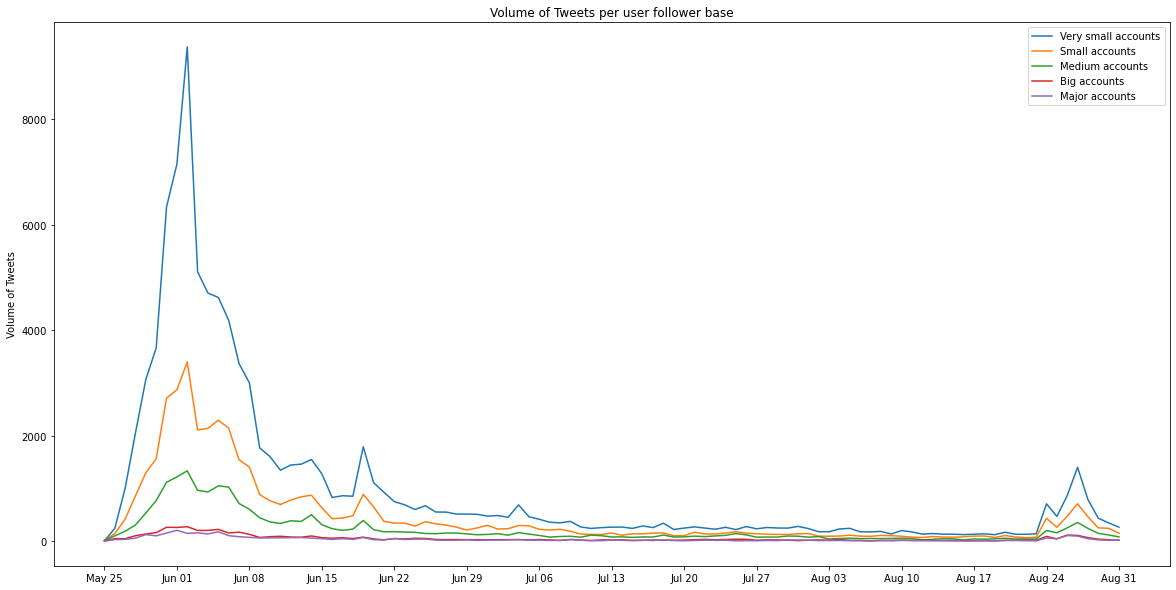

In [134]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byfollow, linestyle='-')
ax.set_ylabel('Volume of Tweets')
ax.set_title('Volume of Tweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

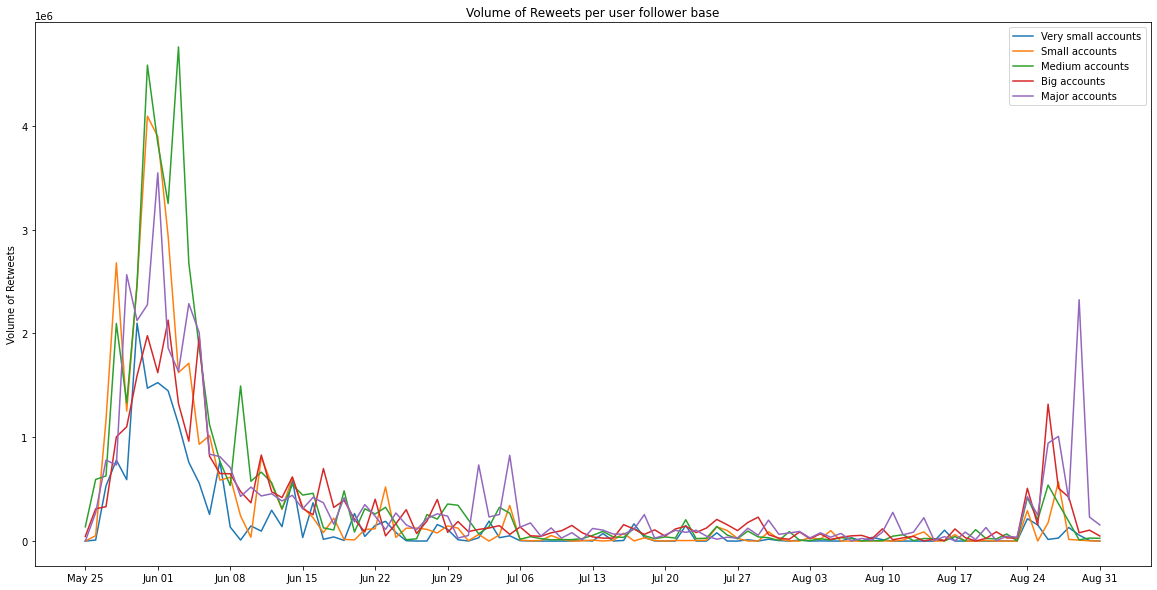

In [135]:
df_byfollow_e = df_cc.groupby(['date','follower_base'])[['retweet_count']].sum().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byfollow_e, linestyle='-')
ax.set_ylabel('Volume of Retweets')
ax.set_title('Volume of Reweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/2587057260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_week['follower_base'] = pd.cut(df_cc_week['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])


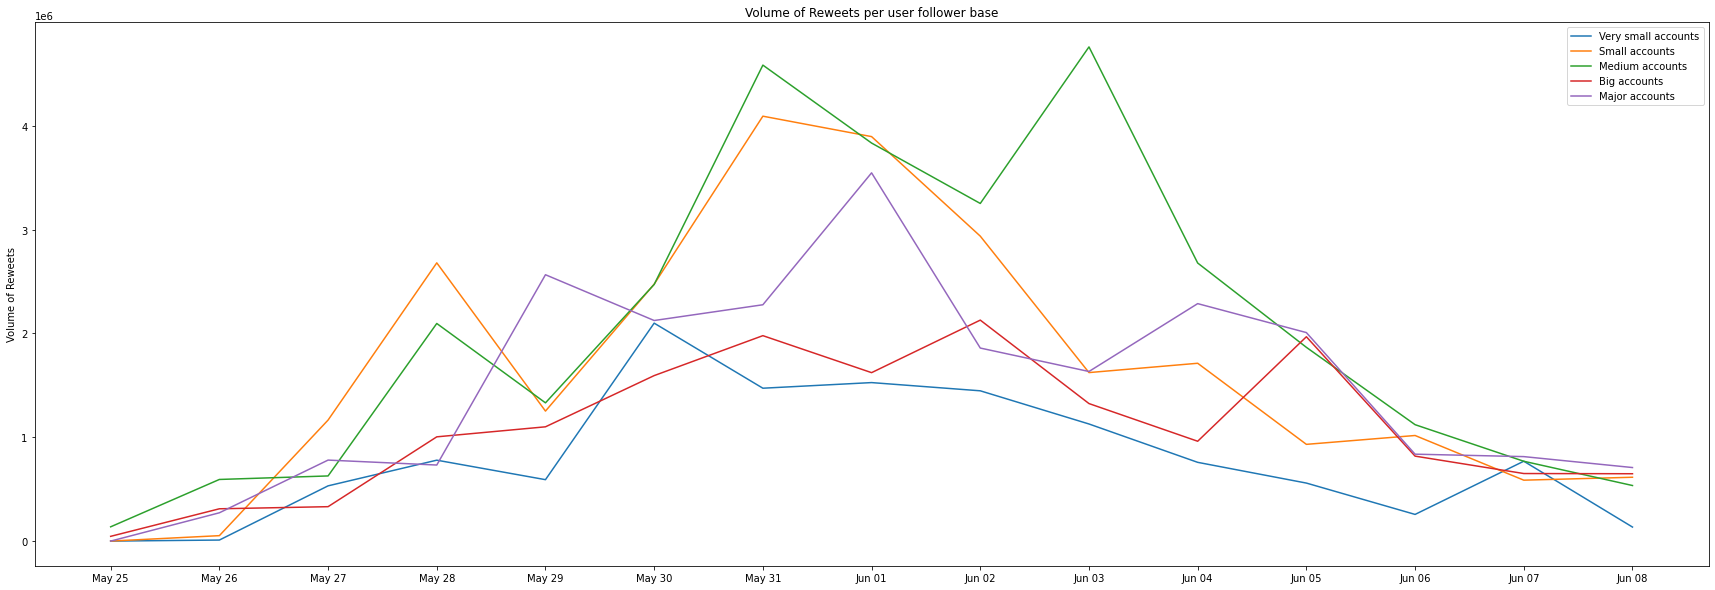

In [136]:
# We zoom on the first two weeks
df_cc_week = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-06-08')]
df_cc_week['follower_base'] = pd.cut(df_cc_week['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_byfollow_weekrt = df_cc_week.groupby(['date','follower_base'])[['retweet_count']].sum().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(df_byfollow_weekrt, linestyle='-')
ax.set_ylabel('Volume of Reweets')
ax.set_title('Volume of Reweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.DayLocator())
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

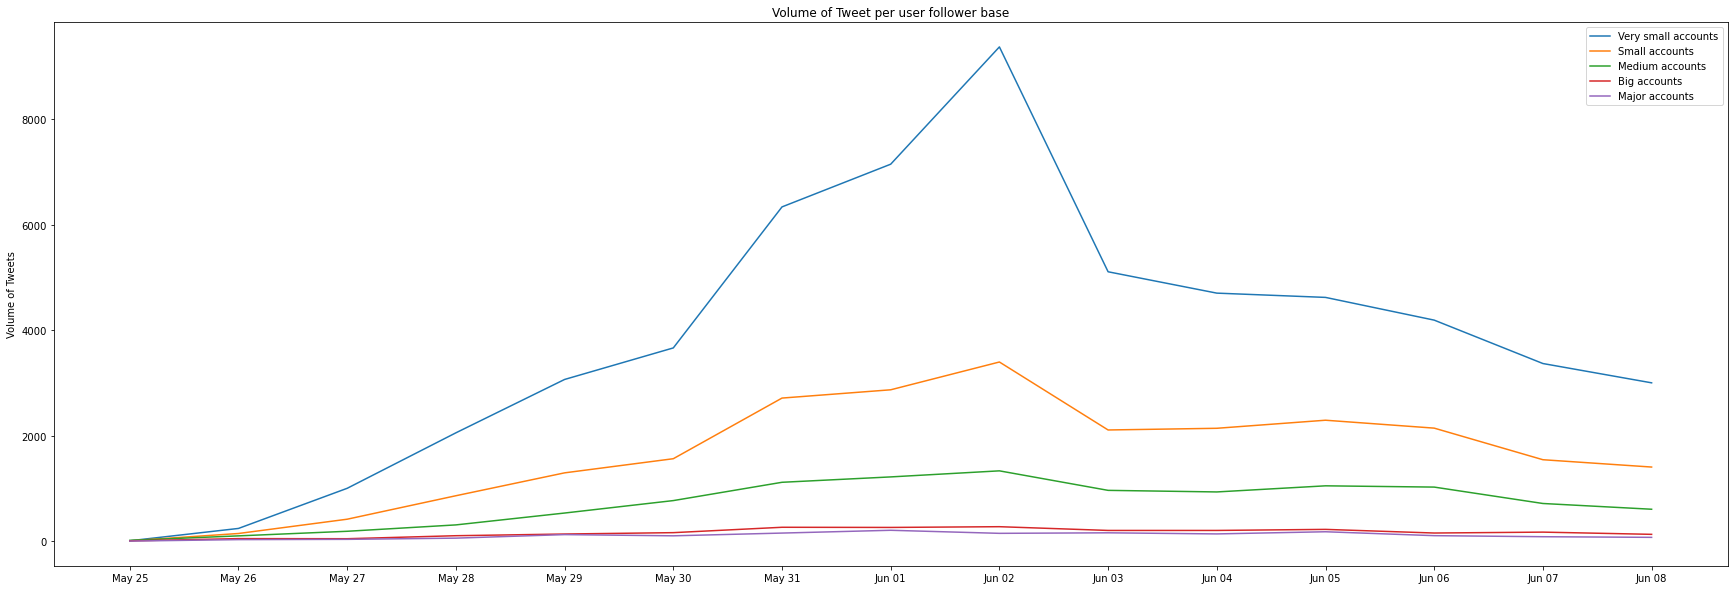

In [137]:
df_byfollow_weektwt = df_cc_week.groupby(['date','follower_base'])[['id']].count().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(df_byfollow_weektwt, linestyle='-')
ax.set_ylabel('Volume of Tweets')
ax.set_title('Volume of Tweet per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.DayLocator())
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

## Defund The Police

In [138]:
df = pd.read_csv("tweetsgf.csv")
df = groupby_date(df)

In [139]:
# Black Lives Matter computation per popularity
follower_base = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_follower_base = df.groupby(follower_base)['id'].count()
df_retweet_count = df.groupby(follower_base)['retweet_count'].sum()

In [140]:
df_summmary_rt = df.groupby(follower_base).agg({'retweet_count': ['sum','mean','max','min']}) 
df_summmary_rt

retweet_count                          
                                sum          mean     max min
user_followers                                               
(0.0, 1000.0]               2063374    328.144720  238782   0
(1000.0, 5000.0]            4979681   1430.120908  331079   0
(5000.0, 100000.0]          7523236   3840.345074  257241   0
(100000.0, 1000000.0]       5692848   8310.727007  139292   0
(1000000.0, inf]            5636340  13882.610837  340481   7

In [141]:
df_summmary_rt

retweet_count                          
                                sum          mean     max min
user_followers                                               
(0.0, 1000.0]               2063374    328.144720  238782   0
(1000.0, 5000.0]            4979681   1430.120908  331079   0
(5000.0, 100000.0]          7523236   3840.345074  257241   0
(100000.0, 1000000.0]       5692848   8310.727007  139292   0
(1000000.0, inf]            5636340  13882.610837  340481   7

In [142]:
# We compute the percentage of retweets per users 
df_summmary_rt['Percentage']= ((df_summmary_rt['retweet_count']['sum'] / df_summmary_rt['retweet_count']['sum'].sum())*100).round(2).astype(str) + '%'

In [143]:
df_summmary_rt

retweet_count                           Percentage
                                sum          mean     max min           
user_followers                                                          
(0.0, 1000.0]               2063374    328.144720  238782   0      7.97%
(1000.0, 5000.0]            4979681   1430.120908  331079   0     19.23%
(5000.0, 100000.0]          7523236   3840.345074  257241   0     29.05%
(100000.0, 1000000.0]       5692848   8310.727007  139292   0     21.98%
(1000000.0, inf]            5636340  13882.610837  340481   7     21.77%

In [144]:
# We now visually represent the evolution of tweets and retweets depending on these ranges.
df_ca = df
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca['date'] = df_ca['date'].dt.strftime('%Y-%m-%d')
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_cc = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-08-31')]
df_cc['follower_base'] = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_byfollow = df_cc.groupby(['date','follower_base'])[['id']].count().unstack().fillna(0)
df_byfollow

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/1731502601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['follower_base'] = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])


id                                      \
follower_base (0.0, 1000.0] (1000.0, 5000.0] (5000.0, 100000.0]   
date                                                              
2020-05-27                0                1                  0   
2020-05-28                1                4                  0   
2020-05-29                3                2                  2   
2020-05-30               13               12                  6   
2020-05-31               66               34                 21   
2020-06-01               75               38                 21   
2020-06-02              106               53                 30   
2020-06-03              124               80                 68   
2020-06-04              157               86                 68   
2020-06-05              268              126                 81   
2020-06-06              205              112                 76   
2020-06-07              290              190                108   
2020-06-08              439              233                111   
2020-06-09              292              173                111   
2020-06-10              236              108                 64   
2020-06-11              151               72                 42   
2020-06-12              142               75                 57   
2020-06-13              132               73                 51   
2020-06-14              157               90                 38   
2020-06-15              141               75                 30   
2020-06-16              119               54                 43   
2020-06-17              125               42                 29   
2020-06-18               94               65                 46   
2020-06-19              111               55                 31   
2020-06-20               86               39                 14   
2020-06-21               50               22                 17   
2020-06-22               67               39                 16   
2020-06-23               92               60                 28   
2020-06-24               94               39                 41   
2020-06-25               82               57                 32   
2020-06-26               71               33                 17   
2020-06-27               62               44                 25   
2020-06-28               57               25                 15   
2020-06-29               63               45                 19   
2020-06-30               88               39                 18   
2020-07-01               61               47                 26   
2020-07-02               50               14                 13   
2020-07-03               42               14                  8   
2020-07-04               43               19                 18   
2020-07-05               38               23                 14   
2020-07-06               38               26                 11   
2020-07-07               40               21                 11   
2020-07-08               34               24                 10   
2020-07-09               43               23                  3   
2020-07-10               35               15                 11   
2020-07-11               32               15                  6   
2020-07-12               30               19                  8   
2020-07-13               27               38                  9   
2020-07-14               27               20                 14   
2020-07-15               35               24                  9   
2020-07-16               52               31                 13   
2020-07-17               54               25                 15   
2020-07-18               38               14                 12   
2020-07-19               34               22                 16   
2020-07-20               36               16                  5   
2020-07-21               35               32                  4   
2020-07-22               37               17                  5   
2020-

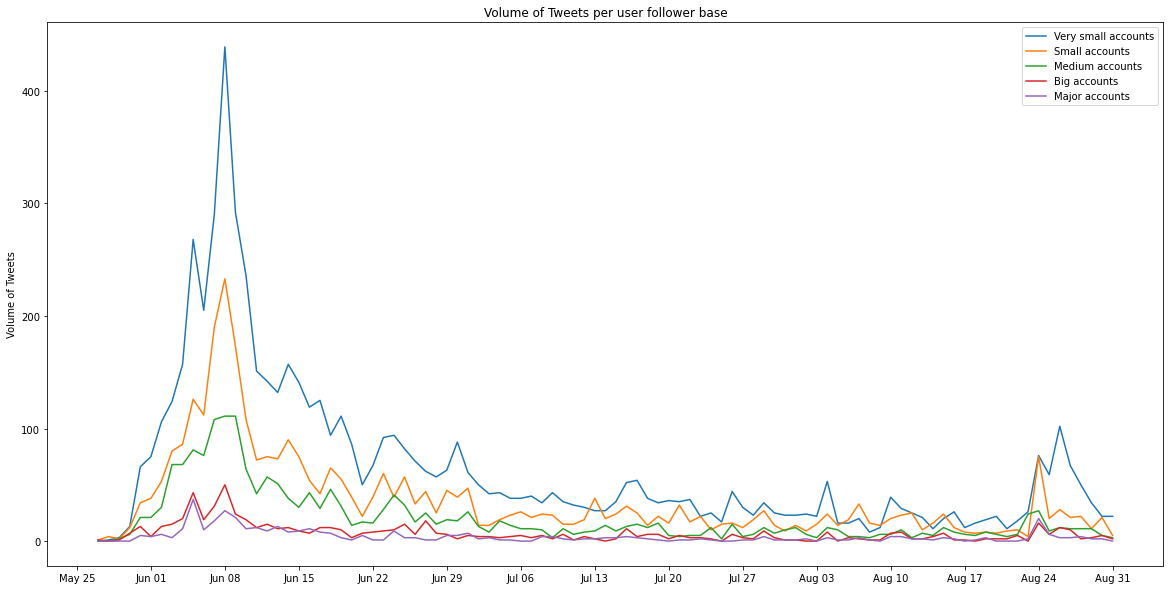

In [145]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byfollow, linestyle='-')
ax.set_ylabel('Volume of Tweets')
ax.set_title('Volume of Tweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

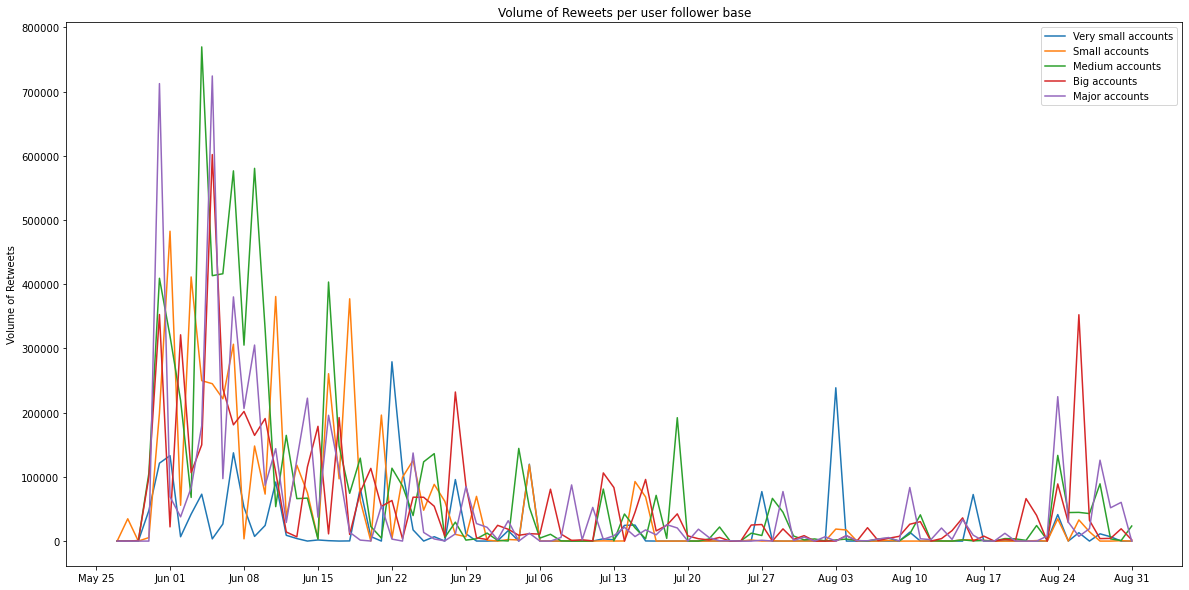

In [146]:
df_byfollow_e = df_cc.groupby(['date','follower_base'])[['retweet_count']].sum().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byfollow_e, linestyle='-')
ax.set_ylabel('Volume of Retweets')
ax.set_title('Volume of Reweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/2587057260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_week['follower_base'] = pd.cut(df_cc_week['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])


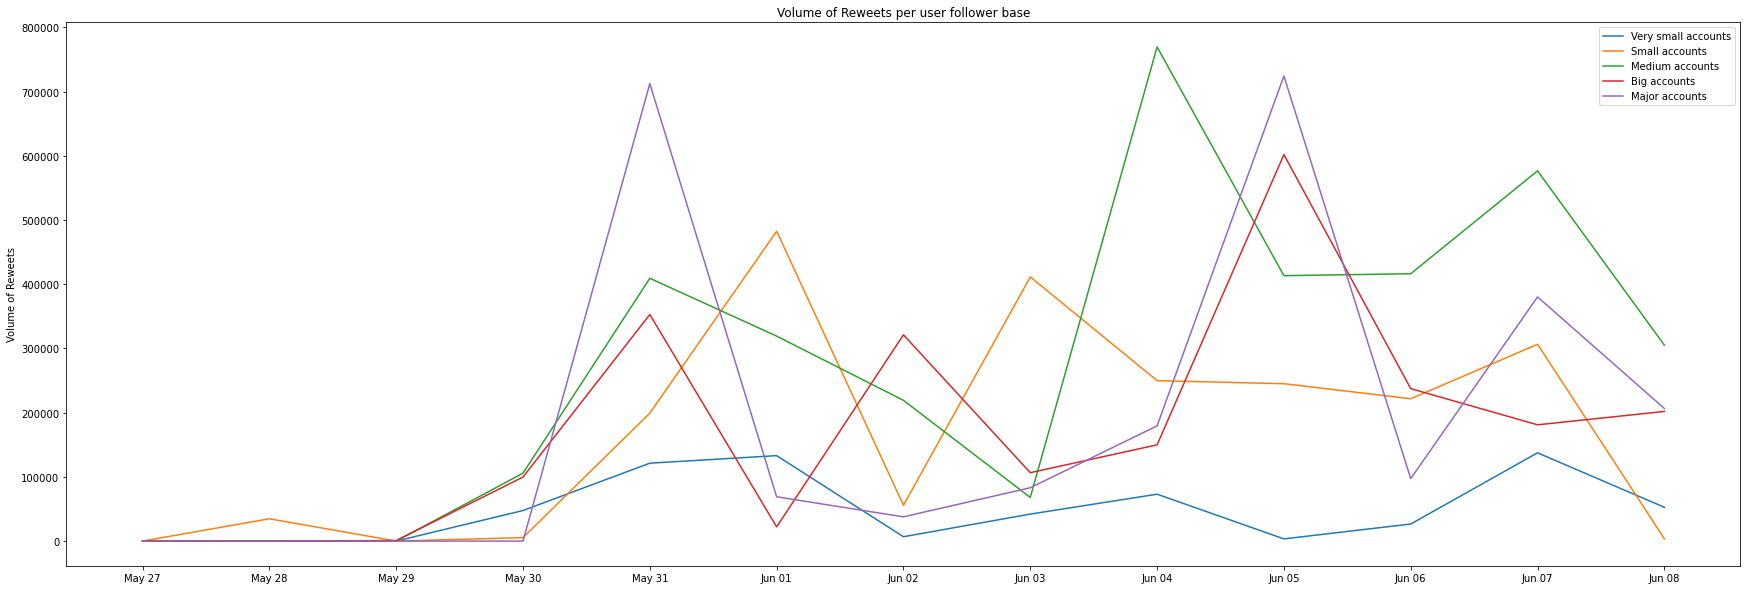

In [147]:
# We zoom on the first two weeks
df_cc_week = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-06-08')]
df_cc_week['follower_base'] = pd.cut(df_cc_week['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_byfollow_weekrt = df_cc_week.groupby(['date','follower_base'])[['retweet_count']].sum().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(df_byfollow_weekrt, linestyle='-')
ax.set_ylabel('Volume of Reweets')
ax.set_title('Volume of Reweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.DayLocator())
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

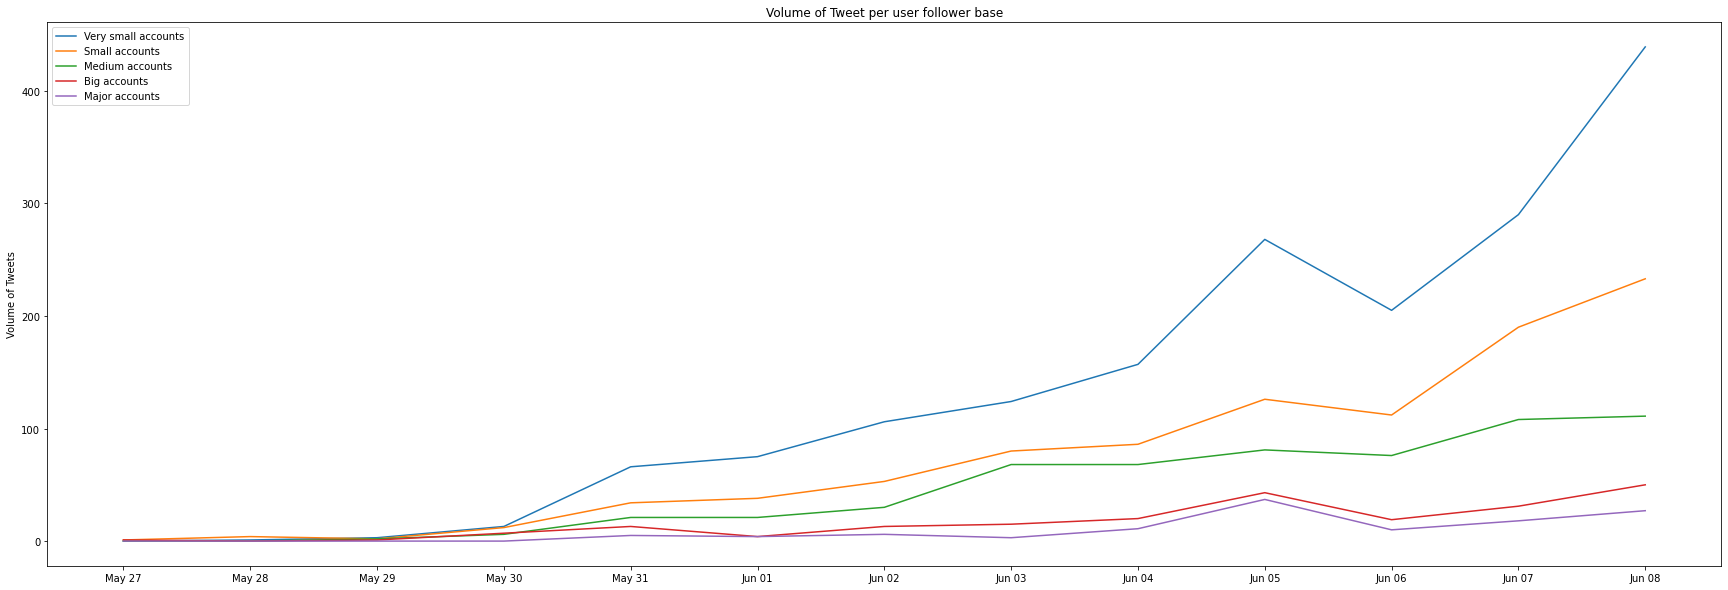

In [148]:
df_byfollow_weektwt = df_cc_week.groupby(['date','follower_base'])[['id']].count().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(df_byfollow_weektwt, linestyle='-')
ax.set_ylabel('Volume of Tweets')
ax.set_title('Volume of Tweet per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.DayLocator())
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

### Reform the police 

In [149]:
df = pd.read_csv("tweetsreform.csv")
df = groupby_date(df)

In [150]:
# Black Lives Matter computation per popularity
follower_base = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_follower_base = df.groupby(follower_base)['id'].count()
df_retweet_count = df.groupby(follower_base)['retweet_count'].sum()

In [151]:
df_summmary_rt = df.groupby(follower_base).agg({'retweet_count': ['sum','mean','max','min']}) 
df_summmary_rt

retweet_count                           
                                sum          mean     max  min
user_followers                                                
(0.0, 1000.0]                  3288     15.152074    3016    0
(1000.0, 5000.0]             153574   1146.074627  150981    0
(5000.0, 100000.0]           131291   2225.271186   78482    0
(100000.0, 1000000.0]        452381  19668.739130   78959   66
(1000000.0, inf]             374199  19694.684211  120948  108

In [152]:
# We compute the percentage of retweets per users 
df_summmary_rt['Percentage']= ((df_summmary_rt['retweet_count']['sum'] / df_summmary_rt['retweet_count']['sum'].sum())*100).round(2).astype(str) + '%'

In [153]:
df_summmary_rt

retweet_count                            Percentage
                                sum          mean     max  min           
user_followers                                                           
(0.0, 1000.0]                  3288     15.152074    3016    0      0.29%
(1000.0, 5000.0]             153574   1146.074627  150981    0     13.78%
(5000.0, 100000.0]           131291   2225.271186   78482    0     11.78%
(100000.0, 1000000.0]        452381  19668.739130   78959   66     40.58%
(1000000.0, inf]             374199  19694.684211  120948  108     33.57%

In [154]:
# We now visually represent the evolution of tweets and retweets depending on these ranges.
df_ca = df
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca['date'] = df_ca['date'].dt.strftime('%Y-%m-%d')
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_cc = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-08-31')]
df_cc['follower_base'] = pd.cut(df['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_byfollow = df_cc.groupby(['date','follower_base'])[['id']].count().unstack().fillna(0)
df_byfollow

id                                      \
follower_base (0.0, 1000.0] (1000.0, 5000.0] (5000.0, 100000.0]   
date                                                              
2020-05-31                0                0                  0   
2020-06-04                1                0                  0   
2020-06-05                1                2                  0   
2020-06-06                1                3                  0   
2020-06-07                8               21                  6   
2020-06-08               27               31                 10   
2020-06-09                6               25                  5   
2020-06-10               16                9                  6   
2020-06-11                2               10                  1   
2020-06-12                2                5                  7   
2020-06-13                6                2                  2   
2020-06-14                3                4                  3   
2020-06-15                5                3                  4   
2020-06-16                7                5                  3   
2020-06-17                2                2                  4   
2020-06-18                6                1                  2   
2020-06-19                9                3                  0   
2020-06-20                5                0                  0   
2020-06-21                2                0                  0   
2020-06-22                3                1                  0   
2020-06-23                2                0                  0   
2020-06-25                3                0                  0   
2020-06-26                1                0                  0   
2020-06-28                0                1                  0   
2020-06-29                1                0                  0   
2020-07-01                4                0                  0   
2020-07-02                1                0                  0   
2020-07-03                3                0                  0   
2020-07-04                1                0                  0   
2020-07-05                0                2                  0   
2020-07-06                1                0                  1   
2020-07-07               14                0                  0   
2020-07-08                4                0                  0   
2020-07-10                0                0                  1   
2020-07-11                1                1                  0   
2020-07-13                1                0                  0   
2020-07-15                1                0                  0   
2020-07-16                0                0                  0   
2020-07-17                1                0                  0   
2020-07-18                1                0                  1   
2020-07-24                2                0                  0   
2020-07-25                1                0                  0   
2020-07-26                1                0                  0   
2020-07-29                1                0                  2   
2020-07-30                1                0                  0   
2020-07-31                1                0                  0   
2020-08-03                5                0                  0   
2020-08-10                1                0                  0   
2020-08-11                3                0                  0   
2020-08-14                1                0                  0   
2020-08-15                1                0                  0   
2020-08-18                4                0                  0   
2020-08-21                3                0                  0   
2020-08-23                3                0                  0   
2020-08-24                5                0                  0   
2020-08-25                7                0                  0   
2020-08-26                4                0                  0   
2020-

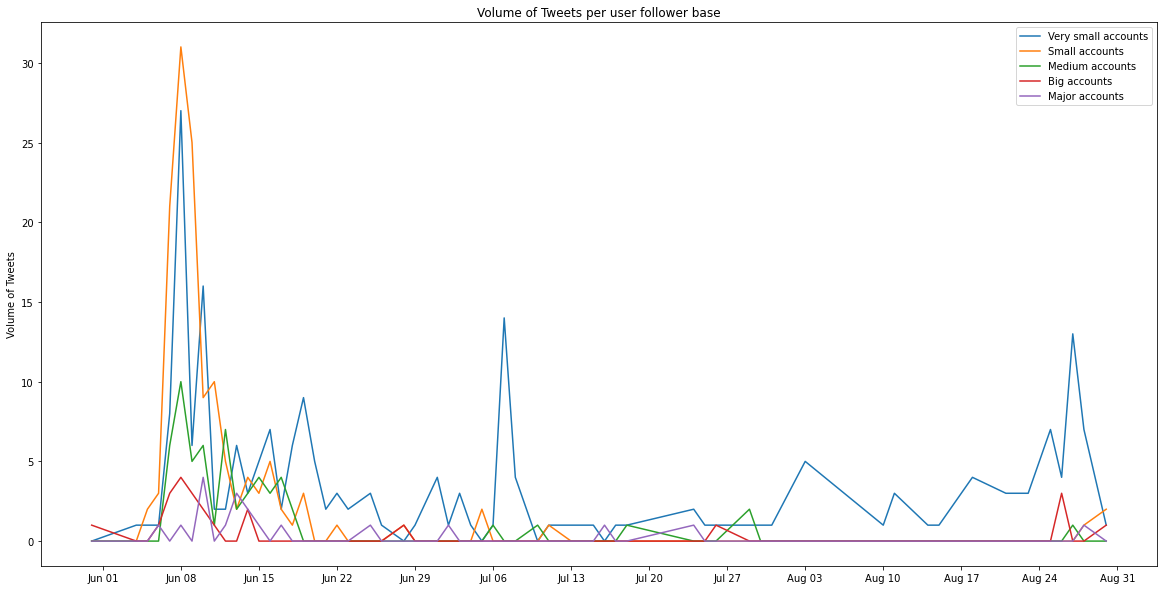

In [155]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byfollow, linestyle='-')
ax.set_ylabel('Volume of Tweets')
ax.set_title('Volume of Tweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

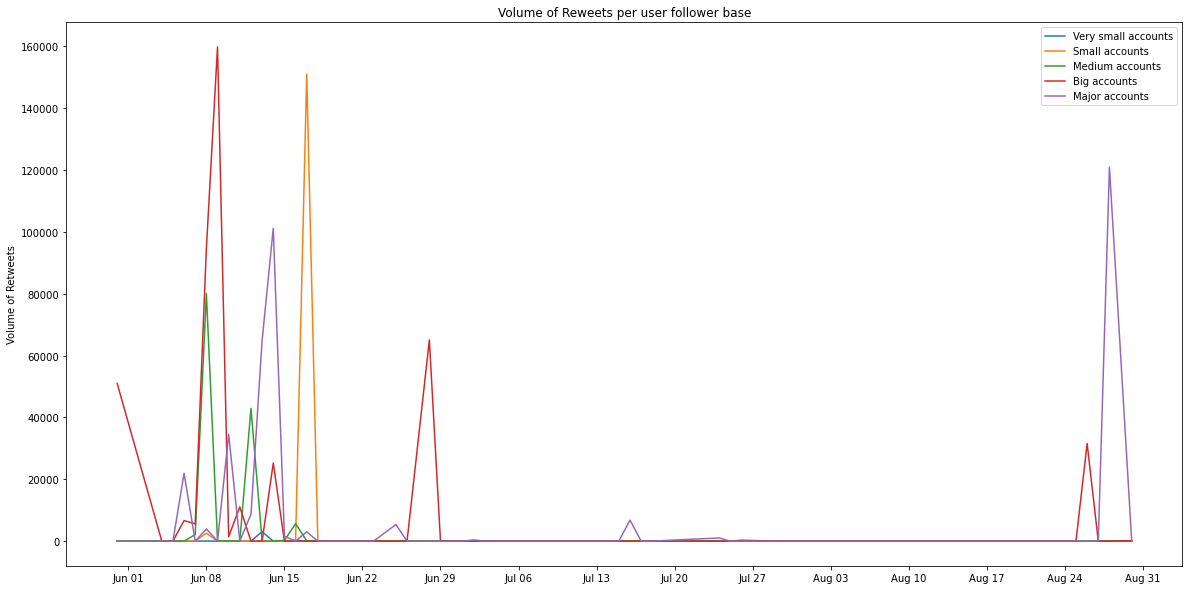

In [156]:
df_byfollow_e = df_cc.groupby(['date','follower_base'])[['retweet_count']].sum().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_byfollow_e, linestyle='-')
ax.set_ylabel('Volume of Retweets')
ax.set_title('Volume of Reweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

/var/folders/74/w7yj9db979s9x9fzb61f8lcc0000gn/T/ipykernel_55088/2587057260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_week['follower_base'] = pd.cut(df_cc_week['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])


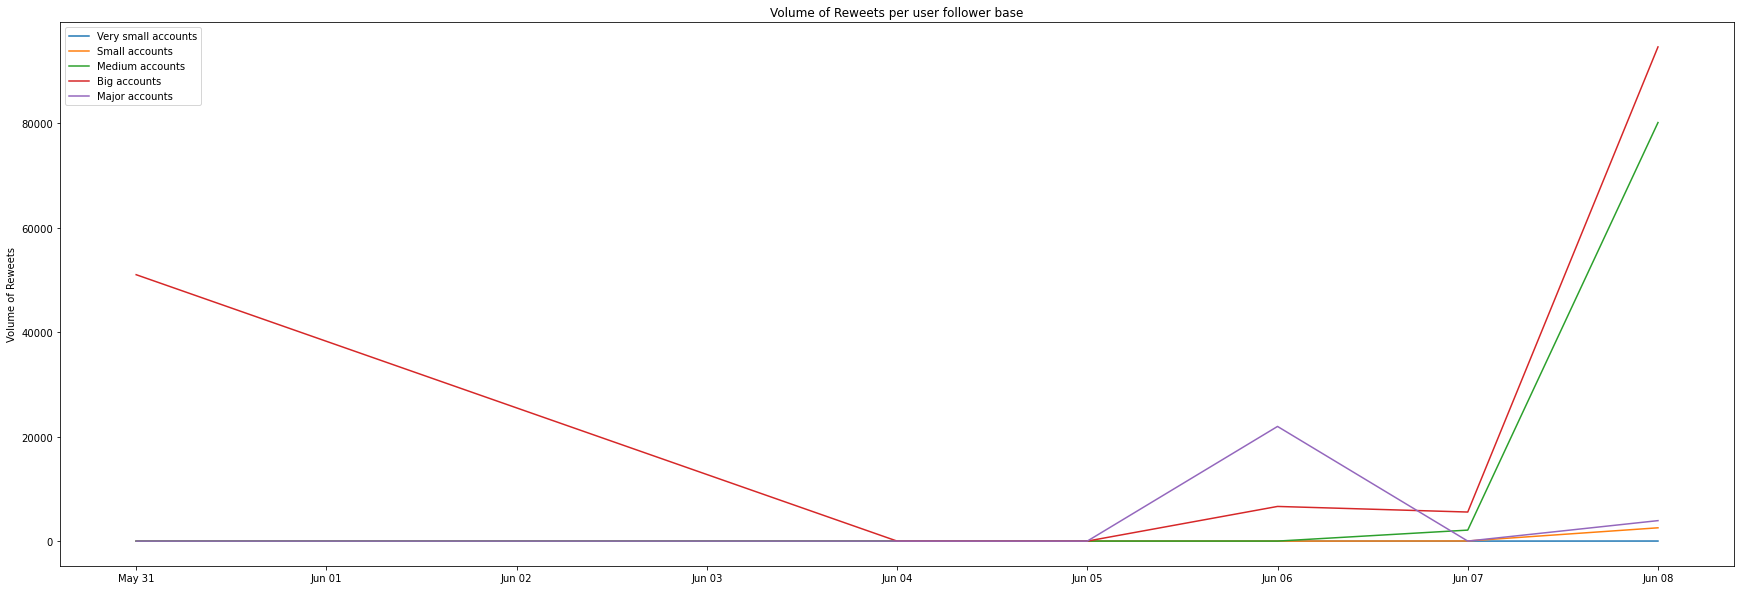

In [157]:
# We zoom on the first two weeks
df_cc_week = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-06-08')]
df_cc_week['follower_base'] = pd.cut(df_cc_week['user_followers'], bins=[0, 1000, 5000, 100000, 1000000, np.inf])
df_byfollow_weekrt = df_cc_week.groupby(['date','follower_base'])[['retweet_count']].sum().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(df_byfollow_weekrt, linestyle='-')
ax.set_ylabel('Volume of Reweets')
ax.set_title('Volume of Reweets per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.DayLocator())
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

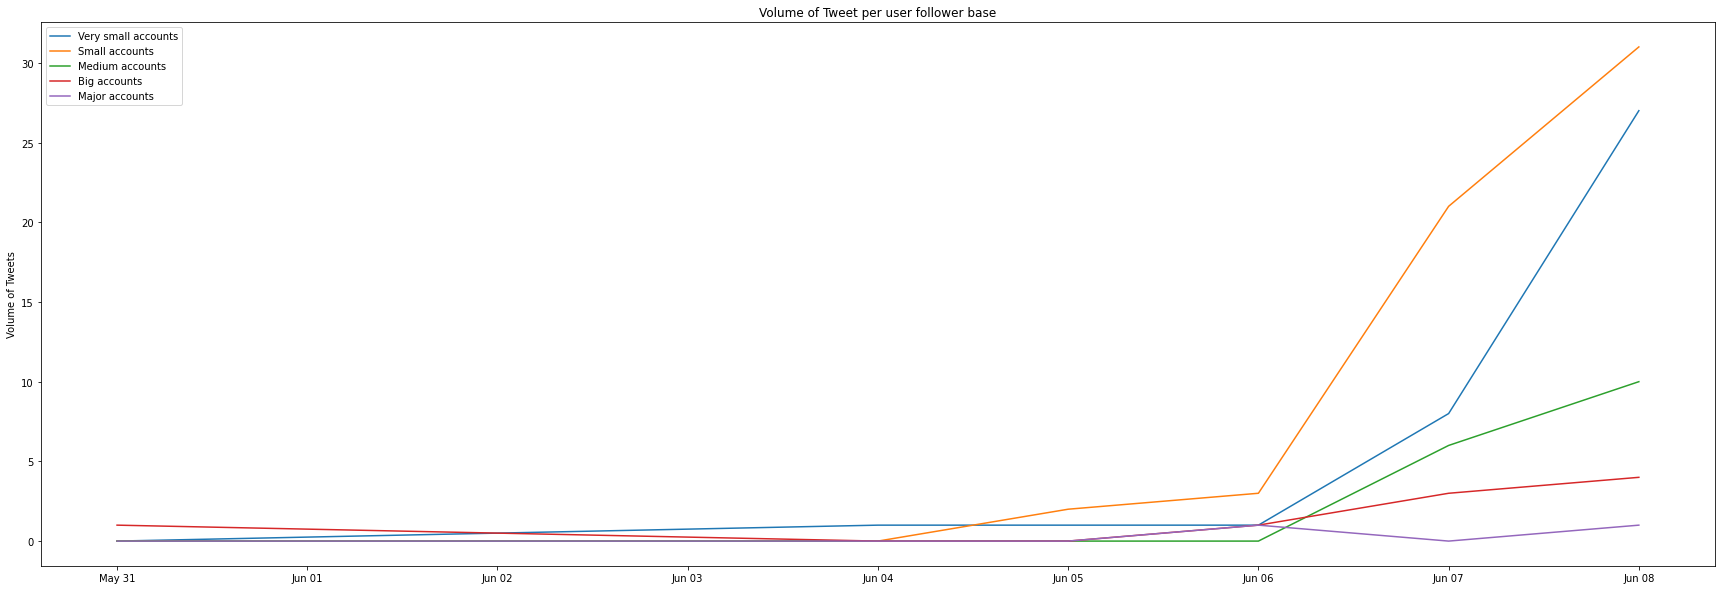

In [158]:
df_byfollow_weektwt = df_cc_week.groupby(['date','follower_base'])[['id']].count().unstack().fillna(0)
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(df_byfollow_weektwt, linestyle='-')
ax.set_ylabel('Volume of Tweets')
ax.set_title('Volume of Tweet per user follower base')
ax.legend(["Very small accounts","Small accounts","Medium accounts", "Big accounts", "Major accounts"])
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.DayLocator())
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

# Qualitative analysis

## Defund The Police most retweeted 

In [160]:
df_ca = pd.read_csv("tweetsgf.csv")
df_ca = groupby_date(df_ca)
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca['date'] = df_ca['date'].dt.strftime('%Y-%m-%d')
df_ca['date'] = pd.to_datetime(df_ca['date'])

In [161]:
df_cc_week = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-06-08')]
ds_week = df_cc_week.sort_values(by='retweet_count', ascending=False)
pd.options.display.max_colwidth = 300
ds_week[['retweet_count','user_followers', 'like_count', 'text', 'user_screen_name', 'date']].head(80)

retweet_count  user_followers  like_count  \
12617         339661         5709102     1244146   
12545         293814            2023      610523   
10781         219588         1215709      788905   
12557         210059         7508932      799013   
10298         192929            3272      614507   
11536         186543            7342      433535   
11233         173585            2069      378123   
12716         164729            7353      250497   
12418         152678           10865      282142   
11564         146663         9274925      537133   
9955          144745           12682      479482   
11709         142401           17981      252387   
11141         141563           18885      212885   
10148         139439         1916491      395672   
12677         139380           74860      548343   
9683          136777            1315      409780   
11278         135221            1794      188062   
9895          134901            4298      448804   
11380         131113            1466      203383   
5863          130488          245567      432013   
12440         127087            6459      304987   
11409         125186          161339      387554   
10876         123726           13373      470472   
7921          119146           40200      430222   
12485         118497            1143      204568   
9148          112149             808      431055   
11532         112138            6913      328399   
10337         111880          309598      222825   
12640         105258            2922      308830   
12745         104892           30029      488256   
9056          100952            5297      655574   
8937           94827            6028      220647   
11877          94420           62060      182656   
12619          93612        12934257      249709   
12737          91448            1251      185710   
12206          88439            3459      188747   
10635          86131           87960      395044   
11718          86065            3377      299635   
9868           84743          319285      134341   
11400          83859          267008      150050   
12340          81190          103606      178674   
11356          79679           30863      157742   
8793           78963          863092      104368   
7162           77583          474889      210952   
12459          75847           19408      159483   
1674           75463          246981      339750   
11750          74722          286114      118666   
9529           72427          325724      217181   
10942          71670           30066      110249   
12583          71086             299      190628   
12608          69065           56753      261770   
6788           67637          123745       98722   
5026           67078             500      164343   
12229          65830         1149078      277104   
10145          65763           36173      326802   
12323          65592            8053      371193   
12683          65580          574836      326360   
12727          64545         7009785      182996   
11004          63867         2005748      332887   
11679          62972        12480032      295070   
10402          60425           19321      104258   
9403           57710         2102945      497979   
11579          57594           44425      188199   
7695           55574            1162       57499   
12331          54838          123029      113233   
10458          53288           33417      142387   
11090          53225         1854509      140169   
9647           52155        11665394      114974   
11416          52152          211781      194516   
8686           51936           51199       55648   
12379          51332             179      108335   
10331          50990          116528       84494   
8867           50924         2005748      131780   
7829           50758           41852       89797   
11661          50694            3668       79159   
9527           50058           25191       86642   
123

## Reform The Police most retweeted

In [162]:
df_ca = pd.read_csv("tweetsreform.csv")
df_ca = groupby_date(df_ca)
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca['date'] = df_ca['date'].dt.strftime('%Y-%m-%d')
df_ca['date'] = pd.to_datetime(df_ca['date'])

In [163]:
df_cc_week = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-06-08')]
ds_week = df_cc_week.sort_values(by='retweet_count', ascending=False)
pd.options.display.max_colwidth = 300
ds_week[['retweet_count','user_followers', 'like_count', 'text', 'user_screen_name', 'date']].head(80)

retweet_count  user_followers  like_count  \
341          78959          863095      104371   
346          78482           14543      378707   
438          50985          116516       84477   
440          21943        33337593      145506   
358          11953          922291       45222   
444           6632          198499       18973   
427           3942          388616       20755   
363           3915         9010931       12650   
296           2524            2259        5009   
403           2090           35227        6490   
306           1872          480008        6346   
368           1798          937582        2872   
412           1553          512631        5215   
321           1384            6996        5182   
370            223           96216        1312   
407             66          513382         282   
424             10            7033          23   
402              9            2011          11   
418              7            1926          14   
420              5            1926           9   
385              4           18572           8   
374              4             816           9   
417              4            1926           6   
335              4            4500          21   
383              3            2067          13   
344              3           63198          11   
429              2            2011           3   
380              2            1926           6   
431              2            1427           7   
378              2            7964           4   
351              2            5709           5   
339              2            7033           9   
411              1            2011           1   
342              1              81           0   
421              1            3060           1   
386              1           18572           1   
425              1            7033          13   
426              1            1010           1   
355              1             816           4   
388              1            2145           7   
366              1             816           2   
365              1             816           1   
364              1             816           1   
433              1            8255           0   
362              1             816           2   
414              0            1926           2   
410              0            1926           0   
409              0            1624           0   
408              0             115           1   
406              0            1599           2   
419              0            1926           2   
416              0            1926           0   
413              0             180           0   
415              0            1926           1   
445              0            4993           0   
422              0            3060           1   
437              0             373           0   
446              0            4993           0   
443              0            3173           0   
447              0             751           0   
442              0            2313           0   
441              0            2313           0   
448              0            1624           0   
439              0              75           0   
436              0            1624           2   
423              0            7033           3   
435              0            1285           0   
434              0            2286           2   
449              0            1624           0   
432              0            8056           1   
450              0              55           0   
405              0             297           0   
428              0             280           1   
430              0             280           0   
391              0            2145           0   
404              0             303           0   
349              0             816           5   
361              0              75           1   
360              0             816           0   
359  

## Abolish The Police most retweeted

In [164]:
df_ca = pd.read_csv("tweetsabo.csv")
df_ca = groupby_date(df_ca)
df_ca['date'] = pd.to_datetime(df_ca['date'])
df_ca['date'] = df_ca['date'].dt.strftime('%Y-%m-%d')
df_ca['date'] = pd.to_datetime(df_ca['date'])

In [165]:
df_cc_week = df_ca.loc[(df_ca['date'] >= '2020-05-25')
                     & (df_ca['date'] <= '2020-06-08')]
ds_week = df_cc_week.sort_values(by='retweet_count', ascending=False)
pd.options.display.max_colwidth = 300
ds_week[['retweet_count','user_followers', 'like_count', 'text', 'user_screen_name', 'date']].head(80)

retweet_count  user_followers  like_count  \
1718         192910            3274      614434   
2054         171913            6592      251461   
1968         146655         9275760      537068   
1674         139423         1916364      395646   
1891         135201            1793      188036   
1509         119133           40199      430205   
1943          96435           64125      140055   
1533          94817            6030      220615   
2000          90986            1019      136657   
1845          86122           87961      395029   
1670          84735          319249      134325   
1922          83847          267014      150034   
2017          81397          845116      124766   
1507          78959          863096      104371   
1629          77574          474884      210936   
2005          74715          286119      118654   
1854          71660           30059      110243   
2013          67631          123737       98716   
2059          65822         1148919      277069   
2194          65031            4448      196537   
1907          62960        12481151      295031   
2103          56170           44036      175765   
1738          53283           33412      142389   
1545          50747           41855       89788   
1650          50053           25191       86629   
1939          49579           62162      132898   
1850          47244             603       79833   
1889          41534          262503       78387   
2139          41163             615       67855   
1672          40857         2732151       82410   
2106          40185            1981      133642   
1912          40067         1167611       60037   
1596          38342           17235      171130   
1961          37349         1215745      163415   
2023          36957             423       47662   
2217          35552            3275       93375   
1941          35194         1279409       76484   
1618          33825         4978234      185542   
1820          32501           23798       60788   
2199          29475             113       45694   
2130          26098         5647308       85458   
1778          24290            1641       60181   
2134          23734            4215       34225   
1240          22436          125238       55471   
1658          19659        52358596       60507   
1732          18275            4594      110974   
1994          17738          123737       32141   
1497          17046         3044095       91331   
2044          16812          123737       27494   
1757          15590             943       40420   
2078          15022         2732152       45220   
1613          14814         5647308       58240   
2142          13044          274794       42126   
2127          12969             489       30908   
1698          12012            4915       26371   
1926          11498            3593       22189   
1959          10199          267014       20995   
2063           9743             862       42506   
1964           9512           14651       46921   
2099           9108            4452       13553   
2157           8471            1564       22151   
1799           8285           12418       13105   
1971           8226          419646       34674   
2025           8201         8557882       32107   
2197           8145           70403       67688   
1575           7382          254326       19407   
1766           7035           97309       22633   
1793           6014          222068       13266   
2166           5375        12546091       17984   
1983           4197           86950        9648   
1827           4113            1321        9065   
1601           3428          161343       23753   
1548           3178        57234001        6171   
1514           3150         2441294       16910   
2031           2882         2695631       20706   
1978           2858            2681        9760   
1823           2760        62673679        5262   
2180           2061         